# AML drug response predictions

TODO: try some different models to predict AML drug responses.

Try some binary classification on the IC50 data with different thresholds, maybe as well as regression on the AUC values.

Focus on regression - we already have classification results.

Feature sets:

- Feature set 1 - binary - whether or not certain genes are mutated in a given patient
- Feature set 2 - continuous - allele frequencies of mutations
- Feature set 3 - continuous - all gene expression measurements (RPKM)
- Feature set 3A/3B - continuous, same as above but for subsets of genes shown to have an effect
- Feature set 4 - binary - relative gene expressions based on the regulatory graph and on housekeeping genes

Models:
- linear regression
- Lasso/LassoCV regression
- ElasticNet/ElasticNetCV regression
- SGD
- Random Forest Regression

yz, 2023-08-17

## 1. Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
rpkm = pd.read_csv('data/RPKM.csv', index_col=0)
drug_data = pd.read_csv('data/Drug_Response.csv', index_col=0)
mutations = pd.read_csv('data/Mutation.csv', index_col=0)

In [3]:
rpkm.index = rpkm.Gene
gene_names = rpkm.Symbol

In [4]:
# transposing the RPKM matrix so that the shape is samples x genes
rpkm_t = rpkm.transpose()

In [5]:
# selected housekeeping genes - Note: these are NOT USED YET!!!
housekeeping_genes = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']

In [6]:
rpkm.shape

(22843, 453)

In [7]:
drug_data.shape

(47650, 4)

In [8]:
rpkm.mean(1)

/tmp/ipykernel_395225/1028747558.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rpkm.mean(1)


Gene
ENSG00000000003   -1.305964
ENSG00000000419    6.920826
ENSG00000000457    3.781071
ENSG00000000460    2.971630
ENSG00000000938    8.084141
                     ...   
ENSG00000273477    0.910838
ENSG00000273483   -0.645964
ENSG00000273486    2.886707
ENSG00000273487   -1.120620
ENSG00000273488    1.639306
Length: 22843, dtype: float64

In [9]:
rpkm.std(1)

/tmp/ipykernel_395225/1958355029.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rpkm.std(1)


Gene
ENSG00000000003    1.807134
ENSG00000000419    0.311342
ENSG00000000457    0.542104
ENSG00000000460    0.668757
ENSG00000000938    1.792015
                     ...   
ENSG00000273477    1.325975
ENSG00000273483    1.288118
ENSG00000273486    0.871925
ENSG00000273487    1.467271
ENSG00000273488    1.017138
Length: 22843, dtype: float64

## 2. Generating mutation features

1. Highly mutated genes: TET2, STAG2, RUNX1, EZH2, JAK2, FLT3, SF3B1, GATA2, WT1, CEBPA, NPM1, KRAS, IDH1, BCOR, TP53, ASXL1, DNMT3A, U2AF1, PTPN11, SRSF2, NRAS, and IDH2
This is a binary matrix with 1 for mutated and 0 for wild-type.
2. Variant allele frequency of highly frequently altered variants (>1%)
'FLT3p.A680V', 'FLT3p.I836del', 'FLT3p.D835Y', 'FLT3p.D835H', 'NRASp.G13D', 'NRASp.Q61H', 'NRASp.Q61K', 'NRASp.G13R', 'NRASp.G12D', 'KRASp.G12D', 'U2AF1p.S34F',  'U2AF1p.Q157P', 'DNMT3Ap.R882H', 'DNMT3Ap.R882C',  'IDH2p.R172K', 'IDH2p.R140Q',
'IDH1p.R132H', 'IDH1p.R132C', 'ASXL1p.G646Wfs*12', 'ASXL1p.G645Vfs*58', 'SF3B1p.K666N', 'SF3B1p.K700E', 'NPM1p.W288Cfs*12', 
'JAK2p.V617F', 'SRSF2p.P95H', 'SRSF2p.P95L''SRSF2p.P95R', 'SRSF2p.P95_R102del',


In [10]:
mutations

,chrom,pos_start,pos_end,ref,alt,labId,tumor_only,genotyper,total_reads,allele_reads,...,amino_acids,codons,existing_variation,variant_class,sift,polyphen,exac_af,short_aa_change,validation,rna_status
0,1,914477,914477,C,T,14-00141,0,mutect,33,17,...,A/T,Gcc/Acc,NaN,SNV,tolerated(0.12),benign(0.002),NaN,p.A551T,not_covered,not_covered
1,1,914477,914477,C,T,14-00141,0,varscan,31,17,...,A/T,Gcc/Acc,NaN,SNV,tolerated(0.12),benign(0.002),NaN,p.A551T,not_covered,not_covered
2,1,914941,914941,G,A,15-00492,0,mutect,74,12,...,A/V,gCa/gTa,NaN,SNV,tolerated(0.11),benign(0.003),NaN,p.A396V,not_done,not_done
3,1,914941,914941,G,A,15-00492,0,varscan,85,19,...,A/V,gCa/gTa,NaN,SNV,tolerated(0.11),benign(0.003),NaN,p.A396V,not_done,not_done
4,1,982281,982281,G,T,14-00676,0,varscan,139,13,...,G/V,gGc/gTc,NaN,SNV,deleterious(0),probably_damaging(0.972),NaN,p.G1111V,not_done,not_found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,Y,13524677,13524677,T,C,13-00557,0,varscan,235,24,...,Y/C,tAc/tGc,rs768476671,SNV,deleterious(0.02),benign(0.003),0.000008,p.Y14C,not_done,not_covered
9906,Y,13524677,13524677,T,C,13-00557,0,mutect,235,24,...,Y/C,tAc/tGc,rs768476671,SNV,deleterious(0.02),benign(0.003),0.000008,p.Y14C,not_done,not_covered
9907,Y,13524713,13524713,A,G,16-01185,0,mutect,41,5,...,V/A,gTt/gCt,rs757454454,SNV,deleterious(0.02),probably_damaging(0.988),0.000042,p.V2A,not_done,not_covered
9908,Y,21897362,21897362,G,A,14-00499,0,varscan,60,26,...,T/M,aCg/aTg,rs746730690,SNV,tolerated(0.16),benign(0.007),0.000072,p.T270M,not_done,not_done


### Mutation Feature Set 1

In [11]:
# mutation dataset 1: binary features
highly_mutated_genes = 'TET2, STAG2, RUNX1, EZH2, JAK2, FLT3, SF3B1, GATA2, WT1, CEBPA, NPM1, KRAS, IDH1, BCOR, TP53, ASXL1, DNMT3A, U2AF1, PTPN11, SRSF2, NRAS, IDH2'
highly_mutated_genes = highly_mutated_genes.split(', ')

In [12]:
# dict of patient ID to a binary array of mutated genes
mutations_to_indices = {x: i for i, x in enumerate(highly_mutated_genes)}
label_mutations = {}
for i, row in mutations.iterrows():
    if row.symbol in mutations_to_indices:
        patient_id = row['labId']
        if patient_id in label_mutations:
            patient_mutations = label_mutations[patient_id]
            patient_mutations[mutations_to_indices[row.symbol]] = 1
        else:
            label_mutations[patient_id] = np.zeros(len(mutations_to_indices))
            label_mutations[patient_id][mutations_to_indices[row.symbol]] = 1
            

In [13]:
# convert this to a numpy array indexed by patient
data_rows = []
sample_ids = rpkm_t.index[2:]
for sample in sample_ids:
    if sample not in label_mutations:
        row = np.zeros(len(mutations_to_indices))
    else:
        row = label_mutations[sample]
    data_rows.append(row)
data_rows = np.array(data_rows)
feature_set_1_table = pd.DataFrame(data_rows)
feature_set_1_table.index = sample_ids
feature_set_1_table.columns = highly_mutated_genes

In [14]:
feature_set_1_table.sum(0)

TET2       50.0
STAG2      22.0
RUNX1      48.0
EZH2       16.0
JAK2       14.0
FLT3      122.0
SF3B1      21.0
GATA2      15.0
WT1        34.0
CEBPA      28.0
NPM1       82.0
KRAS       19.0
IDH1       34.0
BCOR       25.0
TP53       35.0
ASXL1      31.0
DNMT3A     85.0
U2AF1      18.0
PTPN11     22.0
SRSF2      43.0
NRAS       60.0
IDH2       43.0
dtype: float64

### Mutation Feature Set 2

In [15]:
# mutation features 2: allele frequencies of specific mutations
variant_alleles = ['FLT3p.A680V', 'FLT3p.I836del', 'FLT3p.D835Y', 'FLT3p.D835H', 'NRASp.G13D', 'NRASp.Q61H', 'NRASp.Q61K', 'NRASp.G13R', 'NRASp.G12D', 'KRASp.G12D', 'U2AF1p.S34F', 'U2AF1p.Q157P', 'DNMT3Ap.R882H', 'DNMT3Ap.R882C', 'IDH2p.R172K', 'IDH2p.R140Q', 'IDH1p.R132H', 'IDH1p.R132C', 'ASXL1p.G646Wfs*12', 'ASXL1p.G645Vfs*58', 'SF3B1p.K666N', 'SF3B1p.K700E', 'NPM1p.W288Cfs*12', 'JAK2p.V617F', 'SRSF2p.P95H', 'SRSF2p.P95L', 'SRSF2p.P95R', 'SRSF2p.P95_R102del']

In [16]:
alleles_to_indices = {x: i for i, x in enumerate(variant_alleles)}
label_alleles = {}
for i, row in mutations.iterrows():
    allele_name = row.symbol + str(row.short_aa_change)
    if allele_name in alleles_to_indices:
        patient_id = row['labId']
        if patient_id in label_alleles:
            patient_alleles = label_alleles[patient_id]
            patient_alleles[alleles_to_indices[allele_name]] = row['t_vaf']
        else:
            label_alleles[patient_id] = np.zeros(len(alleles_to_indices))
            label_alleles[patient_id][alleles_to_indices[allele_name]] = 1

In [17]:
# convert this to a numpy array indexed by patient
data_rows_alleles = []
sample_ids = rpkm_t.index[2:]
for sample in sample_ids:
    if sample not in label_alleles:
        row = np.zeros(len(alleles_to_indices))
    else:
        row = label_alleles[sample]
    data_rows_alleles.append(row)
data_rows_alleles = np.array(data_rows_alleles)
feature_set_2_table = pd.DataFrame(data_rows_alleles)
feature_set_2_table.index = sample_ids
feature_set_2_table.columns = variant_alleles

In [18]:
feature_set_2_table.sum(0)

FLT3p.A680V            0.340244
FLT3p.I836del          5.000000
FLT3p.D835Y            6.532272
FLT3p.D835H            3.694239
NRASp.G13D             6.952980
NRASp.Q61H             3.309897
NRASp.Q61K             4.972622
NRASp.G13R             1.028823
NRASp.G12D             8.032205
KRASp.G12D             1.766528
U2AF1p.S34F            5.550447
U2AF1p.Q157P           1.720118
DNMT3Ap.R882H         16.445213
DNMT3Ap.R882C         10.845864
IDH2p.R172K            2.528017
IDH2p.R140Q           17.876668
IDH1p.R132H            3.996335
IDH1p.R132C            6.512551
ASXL1p.G646Wfs*12      6.736439
ASXL1p.G645Vfs*58      5.225000
SF3B1p.K666N           5.710010
SF3B1p.K700E           3.179560
NPM1p.W288Cfs*12      41.167174
JAK2p.V617F            7.443407
SRSF2p.P95H           11.614796
SRSF2p.P95L            4.183417
SRSF2p.P95R            2.770658
SRSF2p.P95_R102del     4.399510
dtype: float64

In [19]:
feature_set_2_table.sum(1)

12-00023    0.000000
12-00051    0.000000
12-00066    0.000000
12-00150    0.000000
12-00211    0.000000
              ...   
16-01237    1.000000
16-01254    1.141107
16-01262    0.000000
16-01270    0.000000
16-01272    0.000000
Length: 451, dtype: float64

## 3. Filtering the RPKM matrix

We want to include only the genes with positive RPKM values on at least half the samples.

In [20]:
sample_ids = rpkm_t.index[2:]
rpkm_filtered = rpkm_t.iloc[2:, :]

In [21]:
rpkm_to_include = (rpkm_filtered > 0).sum(0) > rpkm_filtered.shape[0]*0.5

In [22]:
rpkm_filtered = rpkm_filtered.loc[:, rpkm_to_include]
included_genes = gene_names[rpkm_to_include]

In [23]:
included_genes

Gene
ENSG00000000419             DPM1
ENSG00000000457            SCYL3
ENSG00000000460         C1orf112
ENSG00000000938              FGR
ENSG00000000971              CFH
                       ...      
ENSG00000273464    RP11-313P22.1
ENSG00000273466     RP11-548H3.1
ENSG00000273477    RP11-196O16.1
ENSG00000273486    RP11-731C17.2
ENSG00000273488     RP11-114I8.4
Name: Symbol, Length: 17691, dtype: object

In [24]:
rpkm_filtered

Gene,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,...,ENSG00000273437,ENSG00000273447,ENSG00000273448,ENSG00000273449,ENSG00000273456,ENSG00000273464,ENSG00000273466,ENSG00000273477,ENSG00000273486,ENSG00000273488
12-00023,6.886609,3.817626,2.437114,10.131911,1.808987,6.629013,4.506795,6.311961,1.305681,4.512906,...,0.590811,1.239903,2.015624,1.75039,1.924608,0.064702,3.240346,-0.219722,2.230568,0.279923
12-00051,6.438417,3.987133,1.862662,5.014124,0.979265,5.681544,4.660312,4.850069,0.873389,3.896187,...,0.227771,-1.533375,1.644835,0.274336,-1.344744,-1.374691,4.051967,0.676291,1.029501,2.397719
12-00066,6.554495,3.207921,3.36836,10.139119,2.148488,6.223989,4.912694,6.29028,1.475002,4.03124,...,0.419728,1.120049,0.525473,1.954098,-0.537617,0.477504,3.030349,0.518714,2.683986,1.871256
12-00150,6.852558,3.87823,3.332284,5.941063,2.953542,6.995513,4.746799,5.320093,2.825116,3.876903,...,-0.880786,-2.213748,-0.369948,0.405597,1.748546,0.010213,2.723531,2.618279,1.676374,0.217633
12-00211,6.613863,4.528385,2.984168,7.274613,0.786802,6.506518,5.154787,6.552361,2.044008,5.092842,...,1.115146,-0.783358,3.189498,2.809881,1.015917,0.566154,3.105811,1.581949,2.879371,3.125748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16-01237,7.545959,3.148649,2.645294,6.857559,-0.81369,5.150915,4.283219,6.223989,-0.824904,3.019656,...,-2.08276,-1.644746,0.605558,-1.033936,2.971669,-0.374975,2.816061,2.261786,4.070881,-2.21828
16-01254,6.882087,4.077574,3.115359,10.782979,0.041994,6.072984,4.413523,6.468756,1.922086,4.354655,...,1.667458,-1.096109,1.771565,2.552042,1.538641,-2.726305,3.432764,0.625404,2.267735,1.404543
16-01262,7.331555,3.73462,2.98067,6.045946,4.284379,6.271382,3.452191,6.456985,3.265618,5.611339,...,0.774498,2.389366,1.761583,3.292994,3.307611,0.145147,3.927896,1.414241,3.317902,1.970785
16-01270,6.254707,3.811903,2.670554,6.383498,-1.710826,6.434858,4.699056,6.06159,0.528877,2.976729,...,0.834133,-2.143176,4.008076,3.678939,2.676831,-1.033936,2.707132,3.18133,3.403906,2.286737


### Normal-scaling the RPKM matrix

In [25]:
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rpkm_filtered.values)

import pickle
with open('models/rpkm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [26]:
X_scaled.shape

(451, 17691)

In [27]:
rpkm_scaled_filtered = rpkm_filtered
rpkm_scaled_filtered.loc[:] = X_scaled
rpkm_scaled_filtered.is_copy = False

In [28]:
rpkm_scaled_filtered.mean(0)

Gene
ENSG00000000419   -4.352025e-15
ENSG00000000457   -5.514190e-17
ENSG00000000460    2.351408e-15
ENSG00000000938    2.220692e-15
ENSG00000000971   -5.940062e-16
                       ...     
ENSG00000273464    1.723184e-17
ENSG00000273466   -3.910213e-15
ENSG00000273477    3.543605e-16
ENSG00000273486   -2.215523e-16
ENSG00000273488    6.117304e-16
Length: 17691, dtype: float64

In [29]:
rpkm_scaled_filtered.std(0)

Gene
ENSG00000000419    1.00111
ENSG00000000457    1.00111
ENSG00000000460    1.00111
ENSG00000000938    1.00111
ENSG00000000971    1.00111
                    ...   
ENSG00000273464    1.00111
ENSG00000273466    1.00111
ENSG00000273477    1.00111
ENSG00000273486    1.00111
ENSG00000273488    1.00111
Length: 17691, dtype: float64

## Feature set 4 - graph features

TODO: look in Step6 code, download knowledge graphs

TODO: try to use the features selected in the previous models (features selected from the classification models)

In [30]:
KG_reg = pd.read_csv("data/KG_regulatory_graph_Mar1_2023.csv", index_col=0)

In [31]:
KG_reg.index = KG_reg.Target_gene

In [32]:
drug_coefficients = pd.read_csv('data/Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv', index_col=0)

In [33]:
drugs = drug_data.inhibitor.unique()

In [34]:
drug_coefficients

,Drug,Gene,Symbol,coef,Method,Dataset
0,CYT387,ENSG00000038382,TRIO,-0.006071,Lasso,BeatAML
1,CYT387,ENSG00000042980,ADAM28,-0.008872,Lasso,BeatAML
2,CYT387,ENSG00000100139,MICALL1,0.037869,Lasso,BeatAML
3,CYT387,ENSG00000102805,CLN5,0.066814,Lasso,BeatAML
4,CYT387,ENSG00000106799,TGFBR1,0.003103,Lasso,BeatAML
...,...,...,...,...,...,...
6796,KU-55933,ENSG00000268895,A1BG-AS1,0.012543,Lasso,BeatAML
6797,KU-55933,ENSG00000269337,AL591479.1,0.008351,Lasso,BeatAML
6798,KU-55933,ENSG00000273142,RP11-458F8.4,-0.124586,Lasso,BeatAML
6799,KU-55933,KU-55933_RSS,KU-55933_RSS,165.998444,Lasso,BeatAML


In [35]:
from kgfe import gene_names
def generate_drug_graph_features(drugs, expression, KG_reg, drug_coefficients, housekeeping_genes):
    """
    Args:
        drugs - a list of drug names
        expression - a gene expression table, with genes on axis 0 and samples on axis 1
        KG_reg: regulatory knowledge graph
        drug_coefficients:
        housekeeping_genes: a list of housekeeping gene names
    
    Returns:
        drug_data_outputs: a dict of drug name to pandas dataframe
    """
    drug_data_outputs = {}
    housekeeping_genes_ensembl = gene_names.convert('symbol', 'ensembl', housekeeping_genes)
    temp_expression = expression.iloc[:, 2:]
    housekeeping_gene_expression = temp_expression.loc[housekeeping_genes_ensembl]
    for drug in drugs:
        coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
        output_features = []
        print(drug, len(coefficients), 'gene coefficients')
        feature_names = []
        for _, row in coefficients.iterrows():
            gene = row['Gene']
            symbol = row['Symbol']
            if gene in temp_expression.index:
                expression_data = temp_expression.loc[gene]
                # generate features for regulatory genes
                if gene in KG_reg.index:
                    regulators = KG_reg.loc[gene]
                    # only include negative regulators?
                    regulators = regulators[regulators.Coef < 0]
                    for reg_gene in regulators.Regulator:
                        try:
                            reg_gene_ensembl = gene_names.convert('symbol', 'ensembl', [reg_gene])[0]
                            reg_expr = temp_expression.loc[reg_gene_ensembl]
                            ratios = expression_data/reg_expr
                            ratios[ratios >= 1] = 1
                            ratios[ratios < 1] = 0
                            feature_names.append(symbol + '_' + reg_gene)
                            output_features.append(ratios)
                        except:
                            pass
                # generate features for housekeeping genes
                for h_gene_symbol, h_gene in zip(housekeeping_genes, housekeeping_genes_ensembl):
                    h_gene_expr = housekeeping_gene_expression.loc[h_gene]
                    ratios = expression_data/h_gene_expr
                    ratios[ratios >= 1] = 1
                    ratios[ratios < 1] = 0
                    feature_names.append(symbol + '_' + h_gene_symbol)
                    output_features.append(ratios)
        print('features:', len(feature_names))
        drug_data_outputs[drug] = pd.concat(output_features, axis=1)
        drug_data_outputs[drug].columns = feature_names
    return drug_data_outputs

In [36]:
%time drugs_feature4 = generate_drug_graph_features(drugs, rpkm, KG_reg, drug_coefficients, housekeeping_genes)

17-AAG (Tanespimycin) 62 gene coefficients
features: 1186
A-674563 60 gene coefficients
features: 1093
ABT-737 55 gene coefficients
features: 996
AT7519 57 gene coefficients
features: 1008
AZD1480 57 gene coefficients
features: 1009
Afatinib (BIBW-2992) 51 gene coefficients
features: 925
Alisertib (MLN8237) 44 gene coefficients
features: 781
Axitinib (AG-013736) 60 gene coefficients
features: 1111
BEZ235 50 gene coefficients
features: 869
BI-2536 58 gene coefficients
features: 1029
BMS-345541 52 gene coefficients
features: 907
Barasertib (AZD1152-HQPA) 49 gene coefficients
features: 907
Bay 11-7085 58 gene coefficients
features: 1039
Bortezomib (Velcade) 64 gene coefficients
features: 1143
Bosutinib (SKI-606) 55 gene coefficients
features: 978
CHIR-99021 52 gene coefficients
features: 941
CI-1040 (PD184352) 59 gene coefficients
features: 1063
CYT387 64 gene coefficients
features: 1130
Cabozantinib 57 gene coefficients
features: 1082
Canertinib (CI-1033) 59 gene coefficients
features: 1

Is it a problem that most of the features are zero for every sample? Well, maybe, maybe not. It means that most of the features aren't very useful. But hopefully there are enough features that *are* useful?

## 4. Run machine learning

### Analysis functions

In [37]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import pickle # for saving models
import os

def run_analyses(X, analyses, dependent_vars, 
                 model, return_params=False, labels=None,
                 use_random_search=False,
                 save_models=False,
                 save_model_prefix=''):
    """
    Args:
        X - input data
        analyses - list of string (names of the analyses) - drugs in this case
        dependent_var - list of arrays (things to test)
        model - a scikit-learn model
        
        return_params - whether or not to return the model parameters for each CV run. only for linear models.
        labels - list or array of labels for each of the covariates (required when saving the model parameters)
        use_random_search - whether or not to use random parameter search
    
        save_models - whether or not to save all of the models.
        save_model_prefix - filename prefix for the models (could include a path).
        
    Returns: all_cv_scores (list of validation r^2 scores), df (table of parameters
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    weights_results = []
    predicted_values = []
    predicted_r2_values = []
    for analysis, var in zip(analyses, dependent_vars):
        cv_score = []
        train_cv_score = []
        included_subset = (~np.isnan(var))
        X_new = X[included_subset]
        var = var[included_subset]
        predicted_values_analysis = np.zeros(var.shape)
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                model_exists = os.path.exists(filename)
                if model_exists:
                    with open(filename, 'rb') as f:
                        model = pickle.load(f)
                else:
                    if use_random_search:
                        cv_model = rf_grid_search(model, X_new[train_index], var[train_index])
                        model = cv_model.best_estimator_
                    else:
                        model.fit(X_new[train_index], var[train_index])
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                if use_random_search:
                    for k in sorted(param_distributions.keys()):
                        weights.append(model.__dict__[k])
                weights.append(analysis)
                predictions = model.predict(X_new[test_index])
                predicted_values_analysis[test_index] = predictions
                score = r2_score(var[test_index], predictions)
                train_pred = model.predict(X_new[train_index])
                score_train = r2_score(var[train_index], train_pred)
                train_cv_score.append(score_train)
                weights.append(score_train)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                if save_models and not model_exists:
                    with open(filename, 'wb') as f:
                        pickle.dump(model, f)
                cv_round += 1
            all_cv_scores.append(cv_score)
            all_train_cv_scores.append(train_cv_score)
            predicted_r2_values.append(r2_score(var, predicted_values_analysis))
            predicted_values.append(predicted_values_analysis)
            print(analysis)
            print('train r^2 scores:', train_cv_score, np.mean(train_cv_score))
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            print('total r^2: ', predicted_r2_values[-1])
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        columns = list(labels)
        if hasattr(model, 'intercept_'):
            columns.append('intercept')
        if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
            columns.append('alpha')
        if use_random_search:
            for k in sorted(param_distributions.keys()):
                columns.append(k)
        df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_train', 'r2_score_test'])
        return all_cv_scores, df
    else:
        return all_cv_scores

In [38]:
def run_analyses_feature4(X_analyses, analyses, dependent_vars, 
                 model, return_params=False, labels=None,
                 use_random_search=False,
                 save_models=False,
                 save_model_prefix=''):
    """
    Same as above, but there's a different data matrix for each drug.
    
    Args:
        X_analyses - input data; dict of drug name to data matrix, or a function that takes in the analysis name and returns a np array
        analyses - list of string (names of the analyses) - drugs in this case
        dependent_var - list of arrays (things to test)
        model - a scikit-learn model
        
        return_params - whether or not to return the model parameters for each CV run. only for linear models.
        labels - list or array of labels for each of the covariates
            (required when saving the model parameters - only necessary if X_analyses does not return a dataframe)
        use_random_search - whether or not to use random parameter search
    
        save_models - whether or not to save all of the models.
        save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    predicted_values = []
    predicted_r2_values = []
    dfs = {}
    for analysis, var in zip(analyses, dependent_vars):
        weights_results = []
        cv_score = []
        train_cv_score = []
        included_subset = (~np.isnan(var))
        if callable(X_analyses):
            X_new = X_analyses(analysis)
        else:
            X_new = X_analyses[analysis]
        # if X_new is a pd dataframe, convert it to an NP array
        if isinstance(X_new, pd.DataFrame):
            column_names = X_new.columns
            X_new = X_new.to_numpy()
        else:
            column_names = labels
        X_new = X_new[included_subset]
        var = var[included_subset]
        predicted_values_analysis = np.zeros(var.shape)
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                model_exists = os.path.exists(filename)
                if model_exists:
                    with open(filename, 'rb') as f:
                        model = pickle.load(f)
                else:
                    if use_random_search:
                        cv_model = rf_grid_search(model, X_new[train_index], var[train_index])
                        model = cv_model.best_estimator_
                    else:
                        model.fit(X_new[train_index], var[train_index])
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                if use_random_search:
                    for k in sorted(param_distributions.keys()):
                        weights.append(model.__dict__[k])
                weights.append(analysis)
                predictions = model.predict(X_new[test_index])
                predicted_values_analysis[test_index] = predictions
                score = r2_score(var[test_index], predictions)
                train_pred = model.predict(X_new[train_index])
                score_train = r2_score(var[train_index], train_pred)
                train_cv_score.append(score_train)
                weights.append(score_train)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                if save_models and not model_exists:
                    with open(filename, 'wb') as f:
                        pickle.dump(model, f)
                cv_round += 1
            all_cv_scores.append(cv_score)
            all_train_cv_scores.append(train_cv_score)
            predicted_r2_values.append(r2_score(var, predicted_values_analysis))
            predicted_values.append(predicted_values_analysis)
            print(analysis)
            print('train r^2 scores:', train_cv_score, np.mean(train_cv_score))
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            print('total r^2: ', predicted_r2_values[-1])
            # return dataframes
            columns = list(column_names)
            if hasattr(model, 'intercept_'):
                columns.append('intercept')
            if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
                columns.append('alpha')
            if use_random_search:
                for k in sorted(param_distributions.keys()):
                    columns.append(k)
            df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_train', 'r2_score_test'])
            dfs[analysis] = df
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        return all_cv_scores, dfs
    else:
        return all_cv_scores

### Building the test set

In [39]:
drugs = drug_data.inhibitor.unique()

In [40]:
dependent_vars = []
for drug in drugs:
    drug_subset = drug_data[drug_data.inhibitor==drug]
    drug_subset.index = drug_subset.lab_id
    drug_auc_vals = []
    for s in sample_ids:
        try:
            d = drug_subset.loc[s]
            drug_auc_vals.append(d.auc)
        except:
            drug_auc_vals.append(np.nan)
    dependent_vars.append(np.array(drug_auc_vals))

### Feature set 1

In [41]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)


In [42]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor


In [43]:
X = feature_set_1_table.to_numpy()

In [44]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f1_r2, f1_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=feature_set_1_table.columns,
                              save_models=True,
                              save_model_prefix='models/feature1/f1_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.1937693998169262, 0.1542257364001779, 0.17842317024638776, 0.1785380687414876, 0.20643208757734022] 0.18227769255646392
test r^2 scores: [0.12338458796907326, 0.11691296143680008, 0.19155957227524045, 0.14391272273445133, 0.11718412808072654] 0.13859079449925832
total r^2:  0.14422257650874715
A-674563
train r^2 scores: [0.17592962477314067, 0.08970186142351977, 0.1453253208429447, 0.09497919408803568, 0.11857170278553408] 0.12490154078263498
test r^2 scores: [0.04711734869062745, 0.11735045178249814, 0.07452680267234124, 0.09830401956171797, 0.03872582327707297] 0.07520488919685156
total r^2:  0.0824613387331643
ABT-737
train r^2 scores: [0.0, 0.0, 0.0, 0.007958390630473544, 0.03422128110431044] 0.008435934346956797
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, -0.0008302196847116416, -0.04130382181018066, -0.09378231447367003] -0.03749395244710509
total r^2:  -0.014579093242443886
AT7519
train r^2 scores: [0.01376495581807313

In [45]:
f1_coef['model'] = 'lassocv'
f1_coef.to_csv('results/feature1_lassocv_coefs.csv', index=None)

### Feature set 2

In [46]:
X = feature_set_2_table.to_numpy()
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f2_r2, f2_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=feature_set_2_table.columns,
                              save_models=True,
                              save_model_prefix='models/feature2/f2_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.1779323459405413, 0.0, 0.0, 0.1284606836944776, 0.0] 0.06127860592700378
test r^2 scores: [-0.12056222131154004, -0.04158750883764606, -0.008283429828967348, -0.07446345708992896, -0.0024995435444843395] -0.04947923212251335
total r^2:  -0.047227284221098564
A-674563
train r^2 scores: [0.03132075144242352, 0.026851241871599596, 0.07723678687158364, 0.058873839829520325, 0.0647042056897007] 0.05179736514096556
test r^2 scores: [0.06233100805319036, 0.04492788328493702, 5.265491214356821e-05, -0.048466178770824486, -0.06826989899935798] -0.0018849063039823033
total r^2:  0.009578906119612873
ABT-737
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, -0.0008302196847116416, -0.04033820666681831, -0.0731076170708751] -0.03316588993787364
total r^2:  -0.010933765136582174
AT7519
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.025710960973848507] 0.0051421921947697015
test r^2 scores: [-0.017285442

In [47]:
f2_coef['model'] = 'lassocv'
f2_coef.to_csv('results/feature2_lassocv_coefs.csv', index=None)

### Feature set 1/2

In [48]:
X1 = feature_set_1_table.to_numpy()
X2 = feature_set_2_table.to_numpy()
X = np.hstack([X1, X2])
model1 = LassoCV(tol=0.1, selection='random', precompute=True, verbose=False)
f12_r2, f12_coef = run_analyses(X, drugs, dependent_vars,
                              model1,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns]),
                              save_models=True,
                              save_model_prefix='models/feature1_2/f1_2_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.17466776098778825, 0.16471769013986348, 0.18241704415159776, 0.17413078619349287, 0.19830212367659106] 0.17884708102986668
test r^2 scores: [0.13199682439285243, 0.13399566229924997, 0.19255685787962606, 0.1437631529373683, 0.12131674913085755] 0.14472584932799087
total r^2:  0.1503554000252565
A-674563
train r^2 scores: [0.17153088035675235, 0.10009428989559876, 0.18274155045558949, 0.10891035942421323, 0.12205659170027194] 0.13706673436648514
test r^2 scores: [0.062392804554378456, 0.08994506849277595, 0.04418381114499237, 0.08821264717196797, 0.03684536230396285] 0.06431593873361552
total r^2:  0.0712171132121715
ABT-737
train r^2 scores: [0.0, 0.0, 0.0025785686773411864, 0.0, 0.03766897068230646] 0.00804950787192953
test r^2 scores: [-0.03694513776470809, -0.01460826850225505, 0.0013961436594038812, -0.04033820666681831, -0.09707878751540644] -0.037514851357956805
total r^2:  -0.014418098269243007
AT7519
train r^2 scores: [0.0, 0.024481609

In [49]:
f12_coef['model'] = 'lassocv'
f12_coef.to_csv('results/feature1_2_lassocv_coefs.csv', index=None)

### Feature set 3

In [50]:
X = rpkm_scaled_filtered.to_numpy()
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3_r2, f3_coef = run_analyses(X, drugs, dependent_vars,
                              model1, return_params=True,
                              labels=rpkm_scaled_filtered.columns,
                              save_models=True,
                              save_model_prefix='models/feature3/f3_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.613957818774109, 0.6363310661114091, 0.7014465210119063, 0.7651924502232985, 0.6383881163239549] 0.6710631944889356
test r^2 scores: [0.3743644056408938, 0.335367336543288, 0.25923891884351724, 0.19447285024792715, 0.3121510075746329] 0.29511890377005184
total r^2:  0.30729208157776233
A-674563
train r^2 scores: [0.5424865862337138, 0.616481423726588, 0.4062713673108823, 0.8802776071973744, 0.6032182010151514] 0.6097470370967419
test r^2 scores: [0.22867628102802184, 0.2401973599837658, 0.16263387945754715, 0.05332966199161515, 0.20508894940726252] 0.1779852263736425
total r^2:  0.18456572446191677
ABT-737
train r^2 scores: [0.07275878587025919, 0.3401572351122959, 0.5092332531911046, 0.15473844311016127, 0.38189570685839136] 0.29175668482844247
test r^2 scores: [-0.025114346797045384, 0.02967234927254425, 0.04927632467555232, -0.014930139276222665, -0.10031299636130941] -0.012281761697296178
total r^2:  0.011688194435030996
AT7519
train r^2 s

In [51]:
f3_coef['model'] = 'lassocv'
f3_coef.to_csv('results/feature3_lassocv_coefs.csv', index=None)

### Feature set 3a (important genes only, genes with at least one nonzero coefficient from LASSO for the given drug)

In [52]:
def get_f3_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    subset = f3_coef[f3_coef.target == drug]
    # get nonzero genes
    subset_genes = subset.iloc[:, :-6]
    included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return rpkm_scaled_filtered
    return data_subset

In [53]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3a_r2, f3a_coef = run_analyses_feature4(get_f3_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3a/f3a_lassocv')

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

17-AAG (Tanespimycin)
train r^2 scores: [0.9026086872050485, 0.9046077746167658, 0.9039702198556331, 0.9427621249581265, 0.9115817704840169] 0.9131061154239182
test r^2 scores: [0.675054631842946, 0.5767683548164926, 0.5001793914373506, 0.09590458113965983, 0.5902233411613952] 0.4876260600795688
total r^2:  0.5111259200752566
A-674563
train r^2 scores: [0.9512750887462339, 0.952139109946113, 0.9488944555796773, 0.974184244649036, 0.9564764489115856] 0.9565938695665291
test r^2 scores: [0.6764656518630215, 0.5329975444655783, 0.6742813716561997, -0.18444573550681542, 0.51796259025635] 0.44345228454686686
total r^2:  0.4629893461858201
ABT-737
train r^2 scores: [0.6906974949979714, 0.6754076967950364, 0.7700982158027061, 0.636846669559282, 0.749860179098166] 0.7045820512506323
test r^2 scores: [0.4750971711067118, 0.2021870143351414, 0.06126138832656558, 0.4676930597050202, 0.01728764941966998] 0.2447052565786218
total r^2:  0.26213883123383164
AT7519
train r^2 scores: [0.631859157498297

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Alisertib (MLN8237)
train r^2 scores: [0.7740084376074656, 0.684992756588101, 0.5852551882840282, 0.685725924064558, 0.6041232366934968] 0.6668211086475299
test r^2 scores: [-0.4318323522918761, 0.07729531794348488, 0.4329467009851927, 0.20390913280661704, 0.2829900586455828] 0.11306177161780026
total r^2:  0.13286318794842822
Axitinib (AG-013736)
train r^2 scores: [0.7178960521072042, 0.7013190087752439, 0.7966380257977073, 0.8076533140248793, 0.7292160045218277] 0.7505444810453724
test r^2 scores: [0.10974338627821001, 0.4141112501080009, -0.02303173197611952, 0.07711790134745389, 0.3639271248554994] 0.18837358612260893
total r^2:  0.17890944399842756
BEZ235
train r^2 scores: [0.7374887995997288, 0.7838237389022336, 0.9137389000155278, 0.7779186808682335, 0.76637447074665] 0.7958689180264747
test r^2 scores: [0.49393808822051066, 0.46845849606244383, -0.321527655205166, 0.3916367137932758, 0.4784059730068373] 0.30218232317558036
total r^2:  0.28412190638817725
BI-2536
train r^2 score

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Bortezomib (Velcade)
train r^2 scores: [0.8114802424557198, 0.7792928450158518, 0.7288398119310691, 0.7695026076125449, 0.896357912356778] 0.7970946838743928
test r^2 scores: [0.36469003242198816, 0.5815834367996349, 0.4896742681942361, 0.5670772619948887, -0.013592637681688613] 0.39788647234581187
total r^2:  0.38873992150425496
Bosutinib (SKI-606)
train r^2 scores: [0.6903937219628349, 0.601724243453873, 0.6849692943463583, 0.5924447469805467, 0.6072761679222181] 0.6353616349331662
test r^2 scores: [-0.05484316231219921, 0.38481541330983404, -0.08093446814872607, 0.5492853708732406, 0.5549061609462413] 0.27064586293367815
total r^2:  0.2948173071718141
CHIR-99021
train r^2 scores: [0.37792342379248567, 0.35794165609821926, 0.2241023587613521, 0.31459784026056703, 0.28967963720134504] 0.3128489832227938
test r^2 scores: [-0.34431578082390835, -0.05833205702460198, 0.2647154084564928, 0.07641365444388182, 0.23425792357131514] 0.03454782972463588
total r^2:  0.12663732151674878
CI-1040 

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Cabozantinib
train r^2 scores: [0.8717497296344301, 0.9090857566590599, 0.9281530976364174, 0.8632252439068381, 0.8884165428522358] 0.8921260741377963
test r^2 scores: [0.4403316240746913, 0.3425960188110613, -0.0812696614322499, 0.6487081030782338, 0.4345274554236336] 0.356978707991074
total r^2:  0.366183597033762
Canertinib (CI-1033)
train r^2 scores: [0.922500634771201, 0.7313935700707321, 0.801231605585046, 0.7343611669238221, 0.7394984964912795] 0.7857970947684161
test r^2 scores: [-1.1414680892176707, 0.5124502001852167, 0.36077858923312955, 0.5683068788175942, 0.5963890402441427] 0.1792913238524825
total r^2:  0.25708788454187015
Cediranib (AZD2171)
train r^2 scores: [0.7324832530002782, 0.5831936071747202, 0.548900450045475, 0.5787830453768308, 0.6434518932208979] 0.6173624497636404
test r^2 scores: [0.05552560783365912, 0.3091672618576531, 0.5488549453622342, 0.3992938170602969, -0.1858468818056942] 0.2253989500616298
total r^2:  0.24091867992610794
Crenolanib
train r^2 score

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Dasatinib
train r^2 scores: [0.9060607204640534, 0.8448192564391594, 0.8293101798156042, 0.827304259917047, 0.8410921447205996] 0.8497173122712928
test r^2 scores: [0.11271159344122572, 0.5348127822885258, 0.7327548423820682, 0.6108066061752451, 0.5338977317906519] 0.5049967112155433
total r^2:  0.5297074068940496
Doramapimod (BIRB 796)
train r^2 scores: [0.3704867996299369, 0.825453817427381, 0.14410974852431813, 0.7107622525372174, 0.9993318720562769] 0.610028898035026
test r^2 scores: [0.07667868394242261, 0.218503987869627, 0.18957618166977086, -0.11384015528157865, 0.07000836224548279] 0.08818541208914492
total r^2:  0.11225850342562804
Dovitinib (CHIR-258)
train r^2 scores: [0.8815921932598995, 0.9010469417144013, 0.8376290764707619, 0.8407943158129051, 0.9025149913186408] 0.8727155037153217
test r^2 scores: [0.3440775800982613, 0.28137645947383827, 0.513423144990397, 0.6071059952860658, 0.2589242386428272] 0.40098148369827785
total r^2:  0.41605387504862723
Elesclomol
train r^2 

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Entospletinib (GS-9973)
train r^2 scores: [0.9999460117426261, 0.9999693182234911, 0.7621763996589065, 0.5832197540431803, 0.9999671110174011] 0.8690557189371211
test r^2 scores: [-0.4416064068883294, -0.06813167436264789, 0.3492808312423561, 0.158604292848597, -0.006329637557957124] -0.0016365189435962658
total r^2:  0.03124712474192126
Entrectinib
train r^2 scores: [0.5393499747065772, 0.6312188589151055, 0.640661411484856, 0.6464689794221476, 0.582977496545737] 0.6081353442148847
test r^2 scores: [0.33419644206303223, 0.2640889812713132, 0.0032063389839612766, 0.3809578384212039, 0.5049793775125944] 0.297485795650421
total r^2:  0.37173917483482544
Erlotinib
train r^2 scores: [0.730640197722264, 0.6745464339711784, 0.7302223208088909, 0.7096124746684033, 0.7267805941231615] 0.7143604042587797
test r^2 scores: [0.2872985959088783, 0.5263130424844219, 0.412601860750041, 0.24719645273988222, 0.3356623381472015] 0.361814458006085
total r^2:  0.3610713856042089


/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Flavopiridol
train r^2 scores: [0.6884853512782074, 0.7462971038410477, 0.6843134416587183, 0.8247737536362432, 0.7312924281166416] 0.7350324157061716
test r^2 scores: [0.6149794673098611, 0.4417913871028557, 0.6552196614220007, -0.19575605309060595, 0.2686361755074841] 0.35697412765031916
total r^2:  0.4290620066570059
Foretinib (XL880)
train r^2 scores: [0.9413337466128491, 0.9605752939378284, 0.9344858094203314, 0.9567733701821859, 0.9230202077906272] 0.9432376855887643
test r^2 scores: [0.7131792629115797, 0.36294668826250376, 0.5142018093192355, 0.3382141740450405, 0.6481058510033391] 0.5153295571083397
total r^2:  0.5385218682786158
GDC-0879
train r^2 scores: [0.22053084269869838, 0.30491760795204004, 0.1808118542338123, 0.2339327799745261, 0.2374615220322207] 0.23553092137825954
test r^2 scores: [0.15619197404383944, -0.11680897602970108, 0.2504913454894657, 0.15733961939345753, 0.1782095439491309] 0.1250847013692385
total r^2:  0.14080729505386025


/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


GDC-0941
train r^2 scores: [0.7753965681807278, 0.9172583079936711, 0.8617130557946702, 0.8374188239664289, 0.8047213941733813] 0.8393016300217759
test r^2 scores: [0.5122827274332686, -0.06562113744964515, 0.24123074020200275, 0.4723507925404945, 0.6009179564892747] 0.3522322158430791
total r^2:  0.350838229880469
GSK-1838705A
train r^2 scores: [0.8458327914385289, 0.7695651476100748, 0.7956590765524586, 0.79341470044308, 0.7773422015833775] 0.7963627835255039
test r^2 scores: [0.050456105964450604, 0.36426320723821703, 0.42396198696164566, 0.47455123925890386, 0.3312576733369025] 0.32889804255202393
total r^2:  0.3301407889500616
GSK-1904529A
train r^2 scores: [0.5122190062679917, 0.4683489195922713, 0.4415342144099159, 0.48550702633905485, 0.48038926418993444] 0.4775996861598336
test r^2 scores: [0.171788626553242, 0.36568620234569016, 0.4496382603019986, 0.3191805530548767, 0.22437661673144216] 0.3061340517974499
total r^2:  0.3210373868025347
GSK690693
train r^2 scores: [0.4091580

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


GW-2580
train r^2 scores: [0.9679115503138588, 0.9652781571736688, 0.9649530785373006, 0.9796595636153942, 0.9772008159241565] 0.9710006331128758
test r^2 scores: [0.5990275610221527, 0.42077620654206027, 0.4968948607860013, 0.2552556010814798, 0.6555895615447374] 0.48550875819528627
total r^2:  0.48893536231033574
Gefitinib
train r^2 scores: [0.902736659891395, 0.9453330889160315, 0.9349592294371757, 0.9017251334941915, 0.8919403733829869] 0.9153388970243561
test r^2 scores: [0.4436489478483254, 0.009923029447056808, 0.44535362457060523, 0.49599107298675893, 0.5634252727958686] 0.391668389529723
total r^2:  0.40363590212678135


/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Gilteritinib (ASP-2215)
train r^2 scores: [0.9988249136630056, 0.9970963822598996, 0.9954645894479818, 0.6488084211031576, 0.9995473791419817] 0.9279483371232052
test r^2 scores: [0.39431193190852987, 0.4935867230590064, 0.6009798280685736, -0.230425139411496, -0.5886754495589039] 0.133955578813142
total r^2:  0.20796723905285353
Go6976
train r^2 scores: [0.989780551872747, 0.9902577250069975, 0.9742168099831637, 0.9928264195377595, 0.9948657730310094] 0.9883894558863355
test r^2 scores: [0.6273310330418747, -0.03747651774884253, 0.3051169645326208, 0.6552863627137255, 0.17734634457152032] 0.34552083742217976
total r^2:  0.40803670312107987
INK-128
train r^2 scores: [0.6047271142489117, 0.6582642989125054, 0.6322370739796075, 0.65006961881705, 0.7581616751777487] 0.6606919562271647
test r^2 scores: [0.5411973920824023, 0.3233610746799762, 0.40768575930351036, 0.3338076115249494, -0.3255969876688798] 0.25609096998439174
total r^2:  0.28357288905248434
Ibrutinib (PCI-32765)
train r^2 sco

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

JAK Inhibitor I
train r^2 scores: [0.5149802396658951, 0.5538821911738185, 0.5484585589882776, 0.7278146155648866, 0.5860366873873579] 0.5862344585560472
test r^2 scores: [0.50343444619331, 0.31871192304829243, 0.5144553219555139, -0.2128921195482809, 0.33277752569206065] 0.2912974194681792
total r^2:  0.3105243556152961
JNJ-28312141
train r^2 scores: [0.9760687221597318, 0.9724281881389026, 0.9679429616003514, 0.9871264981358339, 0.9712645993254199] 0.9749661938720479
test r^2 scores: [0.762871623486102, 0.6764600368540432, 0.19443444534228527, -0.1406480393556786, 0.6570719560039685] 0.43003800446614415
total r^2:  0.41152685887972507
JNJ-38877605
train r^2 scores: [0.36583484396472854, 0.3229205671621195, 0.44437832219477813, 0.3580947527843039, 0.3375041535619555] 0.3657465279335771
test r^2 scores: [0.13107989705009804, 0.287949159271531, -0.5641394694324933, 0.10700868561061683, 0.07199423897437374] 0.006778502294825262
total r^2:  0.06853577096539121
JNJ-7706621
train r^2 scores

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


JQ1
train r^2 scores: [0.9986572247854163, 0.9976045298314745, 0.9987519743254264, 0.9985985687767439, 0.9990267146812892] 0.9985278024800701
test r^2 scores: [-0.01894404609287248, 0.49163560870370726, 0.5424818001806383, 0.5094524556181028, -0.305011497184146] 0.243922864245086
total r^2:  0.3103297979856918
KI20227
train r^2 scores: [0.8358935645042758, 0.8458764120991908, 0.811127988381886, 0.7615634835242511, 0.9686682948440012] 0.8446259486707209
test r^2 scores: [0.46859363940290044, 0.6529294313576005, 0.3984008063200053, 0.4497847845062398, -0.33568366332104627] 0.32680499965313997
total r^2:  0.30346490349119504
KU-55933
train r^2 scores: [0.7160517791357982, 0.7054421674317037, 0.7532495673250365, 0.6643232816585749, 0.706091205437563] 0.7090316001977353
test r^2 scores: [0.233205096559847, 0.2624139504443179, 0.07421781845809983, 0.45508914525265165, 0.3306349096147926] 0.2711121840659418
total r^2:  0.2784052295870152
KW-2449
train r^2 scores: [0.7217370550375306, 0.853608

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Lapatinib
train r^2 scores: [0.8099031897025841, 0.8803161790713052, 0.8951362681952739, 0.8951941088712728, 0.8659466844881686] 0.8692992860657209
test r^2 scores: [0.718434657706515, 0.2653156815151312, 0.04735427636435452, 0.222011311878198, 0.33350309999777017] 0.3173238054923938
total r^2:  0.3777237531176385
Lenalidomide
train r^2 scores: [0.988171672860943, 0.9490873418158777, 0.90378381882895, 0.9237595959523729, 0.9103144665189027] 0.9350233791954092
test r^2 scores: [-0.2546019046282355, 0.5420300275657575, 0.49599289729090057, 0.5794031725685527, 0.33511229495190453] 0.3395872975497759
total r^2:  0.34505447447437054
Lenvatinib
train r^2 scores: [0.9316711967702702, 0.8703182677979759, 0.8727305443013175, 0.8392345161398915, 0.8610800767432079] 0.8750069203505326
test r^2 scores: [-0.8374439402746479, 0.4090734261358073, 0.29629331646964063, 0.7835474902791766, 0.6312113317695212] 0.25653632487589956
total r^2:  0.4311912169438703
Lestaurtinib (CEP-701)
train r^2 scores: [0.

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Linifanib (ABT-869)
train r^2 scores: [0.9304092160937603, 0.8659346376394961, 0.8220352870394683, 0.8089471671708044, 0.8380123046898743] 0.8530677225266807
test r^2 scores: [0.02836435525597225, 0.28593012631971915, 0.6436241282082249, 0.5887924151258451, 0.5768941313813174] 0.4247210312582158
total r^2:  0.4242424591010273
Lovastatin
train r^2 scores: [0.3207157773903696, 0.26105544990677, 0.18511764380678197, 0.17597109117907161, 0.29707296820970786] 0.24798658609854024
test r^2 scores: [-0.21911846145406266, 0.11795139310957459, 0.24711869065527925, -0.043439660719226, -0.11167880514502282] -0.0018333687106915296
total r^2:  0.04778040653329618
MGCD-265
train r^2 scores: [0.6690333560667356, 0.6398273682143012, 0.7167388619742958, 0.6570639190279506, 0.6485835284920386] 0.6662494067550644
test r^2 scores: [0.2605851915457489, 0.2463646679564866, 0.12053949049898671, 0.28047705422588365, 0.27749842181314766] 0.23709296520805073
total r^2:  0.24403067062947492
MK-2206
train r^2 scor

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Motesanib (AMG-706)
train r^2 scores: [0.8774051010261394, 0.8435321988109336, 0.887681590800197, 0.9070788865009081, 0.9719675109248048] 0.8975330576125966
test r^2 scores: [0.7493420666902169, 0.6881038774933073, 0.37602237516329773, 0.6653095938363809, 0.052625674782076026] 0.5062807175930557
total r^2:  0.48090231662931016
NF-kB Activation Inhibitor
train r^2 scores: [0.7657173580724332, 0.749643728723006, 0.7607925870595158, 0.7936587202252849, 0.8887940081497558] 0.7917212804459991
test r^2 scores: [0.5158843841923522, 0.5947646574279033, 0.5597125580124249, 0.298421862761434, -0.06052453219493659] 0.3816517860398355
total r^2:  0.38854967973113574
NVP-ADW742
train r^2 scores: [0.766069622950333, 0.7802561460516488, 0.7394688464091531, 0.6648200760230285, 0.708584036818324] 0.7318397456504975
test r^2 scores: [0.305014408726736, -0.1072876213135523, 0.3592169916273392, 0.5809399953084808, 0.47453512699647127] 0.322483780269095
total r^2:  0.3593520058044226
NVP-TAE684
train r^2 s

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Nutlin 3a
train r^2 scores: [0.9658459657760645, 0.9581820047963933, 0.9690738873450265, 0.9644069777904729, 0.9723458979963743] 0.9659709467408663
test r^2 scores: [0.5362368611700978, 0.34677473177353857, 0.358093454563682, 0.5156696699995946, -0.004253422600569046] 0.3505042589812688
total r^2:  0.3789479986960437
PD173955
train r^2 scores: [0.8962239434236677, 0.8714818808314271, 0.8833858658354585, 0.8685098202130717, 0.930199854235842] 0.8899602729078934
test r^2 scores: [0.6104234933164807, 0.6237516970550079, 0.43507170128673023, 0.4589521849477072, 0.18593624625530292] 0.46282706457224576
total r^2:  0.47177877174572325
PHA-665752
train r^2 scores: [0.5418039768575555, 0.5251918089345753, 0.523830125110808, 0.591975905705733, 0.5637590153728689] 0.5493121663963081
test r^2 scores: [0.1904706858024754, 0.3073255516720902, 0.21329304024133378, 0.1107297910314764, 0.37267776946329645] 0.23889936764213443
total r^2:  0.24039447364774125
PHT-427
train r^2 scores: [0.487628164180428

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


PLX-4720
train r^2 scores: [0.7307450854007823, 0.49430920695428215, 0.0, 0.9668010682978085, 0.7700826102871756] 0.5923875941880098
test r^2 scores: [0.07109419436189357, 0.09935072100663922, -0.008979593246616568, 0.10646694246624244, 0.10527622406092985] 0.0746416977298177
total r^2:  0.08539033861875045
PP242
train r^2 scores: [0.5366190282752743, 0.6761710063099989, 0.5169225738232663, 0.5223181300381496, 0.5813447077299947] 0.5666750892353367
test r^2 scores: [0.3139961618517726, -0.1607749113940904, 0.42759448010210943, 0.284718856852451, -0.03200042090755484] 0.16670683330093755
total r^2:  0.20655262170906719
PRT062607
train r^2 scores: [0.8188892370973322, 0.8247068599473738, 0.7794590506871242, 0.8485017847783967, 0.9711533050907483] 0.848542047520195
test r^2 scores: [0.6319708306370643, 0.5960728785976221, 0.4344982157733447, 0.6362942250203996, -0.5506878603253702] 0.34962965794061207
total r^2:  0.3624922819223251


/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Palbociclib
train r^2 scores: [0.9606414914501483, 0.9857676502314441, 0.9530013746268516, 0.9648838764149997, 0.9883328624686463] 0.9705254510384179
test r^2 scores: [0.6698962706690841, -0.25013234480661106, 0.8706925578730522, 0.8416226719559962, 0.17215286335015845] 0.460846403808336
total r^2:  0.5041464719638092
Panobinostat
train r^2 scores: [0.9765463703447603, 0.9551740602863712, 0.9622602650222047, 0.9863057989005517, 0.972921394252228] 0.9706415777612232
test r^2 scores: [0.32219895886978245, 0.6088663300581453, 0.8151209384095783, 0.5811260999288044, 0.20527222586498095] 0.5065169106262581
total r^2:  0.5326148483345456
Pazopanib (GW786034)
train r^2 scores: [0.7085903125495326, 0.7702759863152524, 0.8124613651335528, 0.7275461342471965, 0.7587524793784663] 0.7555252555248002
test r^2 scores: [0.4704621435803419, 0.1481470048565814, 0.15323762447301303, 0.43953079528383776, 0.32601219073856824] 0.3074779517864684
total r^2:  0.3406672796992142
Pelitinib (EKB-569)
train r^2 

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Ponatinib (AP24534)
train r^2 scores: [0.9836134378672773, 0.9938364859011827, 0.9894021168510765, 0.9908645913429215, 0.9898888648700426] 0.9895210993665001
test r^2 scores: [0.43577923429777266, 0.3493304411398229, 0.39984846114477024, 0.28936451293962895, 0.5692446626074181] 0.4087134624258826
total r^2:  0.4073469017102096
Quizartinib (AC220)
train r^2 scores: [0.762804592321157, 0.7850018960567684, 0.8531616283779296, 0.7636655249506961, 0.778578932153902] 0.7886425147720907
test r^2 scores: [0.5711866721323433, 0.39428476612515584, 0.05935770989267042, 0.5159712682206428, 0.3926795780707406] 0.3866959988883106
total r^2:  0.397518149461617
RAF265 (CHIR-265)
train r^2 scores: [0.887319224742058, 0.7462829049039352, 0.7219838095661242, 0.7239803504077451, 0.7424932499770911] 0.7644119079193907
test r^2 scores: [-0.1846081322461708, 0.2773173120146639, 0.5533393897620533, 0.4555687963720181, 0.37688539903425167] 0.29570055298736325
total r^2:  0.2644325199512526
Rapamycin
train r^2 

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Regorafenib (BAY 73-4506)
train r^2 scores: [0.8480743267461242, 0.8362033550824552, 0.8598492508260145, 0.8359535349343041, 0.8201168420077587] 0.8400394619193314
test r^2 scores: [0.3786723059305285, 0.4893968945914713, 0.3149772719608428, 0.24571562764849764, 0.5466865251346025] 0.39508972505318857
total r^2:  0.40681568836272164
Roscovitine (CYC-202)
train r^2 scores: [0.24025847833156266, 0.5887819536817316, 0.4351373759592163, 0.38016209677348756, 0.4050403335090256] 0.40987604765100477
test r^2 scores: [0.2277575936475862, -0.295199553415864, 0.038444396265435055, 0.3154838294050295, 0.17596453091414987] 0.09249015936326732
total r^2:  0.04950284172567887
Ruxolitinib (INCB018424)
train r^2 scores: [0.2096332774763039, 0.22362918452671932, 0.24143954152725566, 0.21401718416213678, 0.2719029223006775] 0.23212442199861863
test r^2 scores: [0.2115347235981485, 0.160940565411809, -0.16261128190053098, 0.19258390262632785, 0.011978121366136074] 0.0828852062203781
total r^2:  0.1285626

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Saracatinib (AZD0530)
train r^2 scores: [0.9361040704601796, 0.9675151424885171, 0.9376846486769108, 0.9335452136070015, 0.9656703034982173] 0.9481038757461653
test r^2 scores: [0.47217290896743513, -0.11722792505733892, 0.6491497460722175, 0.6705444050715936, 0.07588669269121473] 0.35010516554902443
total r^2:  0.38590909171404375
Selinexor
train r^2 scores: [0.697712096186837, 0.6478512034879311, 0.7012592992080002, 0.6688724863376947, 0.6318072816234709] 0.6695004733687868
test r^2 scores: [0.099677113987504, 0.03868974548706905, -0.033581629079224795, 0.506742916666947, 0.5572450187765168] 0.2337546331677624
total r^2:  0.25027399721589416
Selumetinib (AZD6244)
train r^2 scores: [0.6737592497351064, 0.7748815506656375, 0.7067211719406716, 0.6641715573245066, 0.680356060564133] 0.6999779180460111
test r^2 scores: [0.3725214981592072, 0.0002905635890639857, 0.3831618795649552, 0.49799316672051674, 0.41454008715116786] 0.3337014390369822
total r^2:  0.32544303026037047
Sorafenib
train

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Sunitinib
train r^2 scores: [0.9250421968951419, 0.910476599838909, 0.9143668328340812, 0.9361002654629448, 0.9241797126678132] 0.9220331215397779
test r^2 scores: [0.4398852997885683, 0.6893942695500646, 0.4231769687963135, 0.3477187322046612, 0.4553921361567185] 0.4711134812992652
total r^2:  0.4858059136031201
TG100-115
train r^2 scores: [0.1989342085516631, 0.22163081049848077, 0.16360106229315619, 0.22653245268080946, 0.18789068877886828] 0.19971784456059555
test r^2 scores: [0.04565031679317055, 0.022724606557912197, 0.24073913280939463, -0.08758221823322843, 0.10782304484783867] 0.06587097655501753
total r^2:  0.057209344072826185
TG101348
train r^2 scores: [0.6082049768281308, 0.7536233345019615, 0.5898741426851328, 0.5918486743508609, 0.5451718432252246] 0.6177445943182621
test r^2 scores: [-0.15823343203173756, -0.3601027949478881, 0.43162937323660644, 0.11578405024408411, 0.5411927670777691] 0.1140539927157668
total r^2:  0.1063189215082202
Tandutinib (MLN518)
train r^2 scor

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Trametinib (GSK1120212)
train r^2 scores: [0.9867986918101688, 0.9302920293265791, 0.9559879987379518, 0.9509451751101133, 0.9655309353245829] 0.9579109660618792
test r^2 scores: [0.09819961124639642, 0.5825028659718763, 0.7358161282856157, 0.7098864580798812, 0.5340519296025992] 0.5320913986372737
total r^2:  0.5473380580923337
VX-745
train r^2 scores: [0.5581989692994559, 0.5779959766694962, 0.49728943435510586, 0.4937347935197496, 0.5171265394580239] 0.5288691426603663
test r^2 scores: [0.01613567741803501, 0.09605158392050694, 0.39029026917709286, 0.3648213189637698, 0.39387670088297266] 0.25223511007247545
total r^2:  0.28443908090604775
Vandetanib (ZD6474)
train r^2 scores: [0.7716547019610874, 0.735230352387237, 0.6668269033051478, 0.655387734825259, 0.7587645677989677] 0.7175728520555398
test r^2 scores: [0.11914640886590866, 0.0799269476630774, 0.6287395333248609, 0.25914661612617373, 0.014682992663010208] 0.2203284997286062
total r^2:  0.2690387922986751
Vargetef
train r^2 sc

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Vismodegib (GDC-0449)
train r^2 scores: [0.0, 0.0, 0.0, 0.0, 0.0] 0.0
test r^2 scores: [-0.00011605930969826872, -0.7150812678710017, -0.005126800989624591, -0.0063091429274899635, -0.02420210350838392] -0.15016707492123968
total r^2:  -0.009050640427823886
Volasertib (BI-6727)
train r^2 scores: [0.01161061905325489, 0.01370069574133459, 1.1102230246251565e-16, 0.0, 1.1102230246251565e-16] 0.00506226295891794
test r^2 scores: [0.006858844428718314, -0.010156220569996988, -0.0010622860352269559, -0.04287668955184576, -0.005472529589491737] -0.010541776263568624
total r^2:  -0.0030690328667488664
XAV-939
train r^2 scores: [0.42890044967477936, 0.4504500921147351, 0.4832020051837289, 0.4105403065120202, 0.5523628596441674] 0.4650911426258862
test r^2 scores: [0.3438278185020992, 0.26485001452450907, -0.30093970636358947, 0.4257813696445377, -0.1623484941952189] 0.11423420042246753
total r^2:  0.16766619456679954
YM-155
train r^2 scores: [0.9512804138577109, 0.928818190214751, 0.9202625712

/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/2784002335.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


In [54]:
for key, df in f3a_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3a/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b (genes from the file Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv)

In [55]:
def get_f3b_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return rpkm_scaled_filtered
    return data_subset

In [56]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3b_r2, f3b_coef = run_analyses_feature4(get_f3b_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3b/f3b_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.6896469619936647, 0.7368575569259285, 0.7702934989672364, 0.7407605691794814, 0.7224557010716721] 0.7320028576275966
test r^2 scores: [0.6933386790956373, 0.5654598495950667, 0.3932354308954963, 0.4763819027191307, 0.6214856734570888] 0.5499803071524839
total r^2:  0.5650883793804184
A-674563
train r^2 scores: [0.7064632215604605, 0.7228493020864508, 0.7332173389098825, 0.7227765571463238, 0.7183197688102507] 0.7207252377026736
test r^2 scores: [0.6048465854436245, 0.5214059427905728, 0.5518977118909757, 0.561949170249578, 0.5428685234954677] 0.5565935867740437
total r^2:  0.5612084908803058
ABT-737
train r^2 scores: [0.6951947020259235, 0.6907443088363348, 0.682290494663826, 0.6743209087009903, 0.7049094710339815] 0.6894919770522112
test r^2 scores: [0.4974305028584486, 0.47304556248454876, 0.5430925016795085, 0.5797673695832525, 0.3699099682841136] 0.4926491809779744
total r^2:  0.5088913800172681
AT7519
train r^2 scores: [0.6317139575193303

In [57]:
for key, df in f3b_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3b/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3

In [58]:
X1 = feature_set_1_table.to_numpy()
X2 = feature_set_2_table.to_numpy()
X3 = rpkm_scaled_filtered.to_numpy()
X = np.hstack([X1, X2, X3])
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f123_r2, f123_coef = run_analyses(X, drugs, dependent_vars,
                              model1, return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns, rpkm_scaled_filtered.columns]),
                              save_models=True,
                              save_model_prefix='models/feature1_2_3/f123_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.6431806961332913, 0.6381229760326949, 0.6822765648690909, 0.7480079018726158, 0.7034596603357782] 0.6830095598486943
test r^2 scores: [0.3645120731323478, 0.32700483774612366, 0.23625025213115047, 0.17791768059390434, 0.3066635259373135] 0.28246967390816796
total r^2:  0.29488717001637843
A-674563
train r^2 scores: [0.601946169456237, 0.6650088067477404, 0.43614146163887346, 0.8935046879227653, 0.6036585477028702] 0.6400519346936973
test r^2 scores: [0.24228986754433357, 0.27176070988918166, 0.16996820948150493, 0.0780663919260659, 0.19127655311079284] 0.19067234639037578
total r^2:  0.1977914265554559
ABT-737
train r^2 scores: [0.0970515941833976, 0.44651051061835456, 0.15419019615836782, 0.15457876908569979, 0.44044812826473034] 0.25855583966211004
test r^2 scores: [-0.02396879712247091, 0.0028863552766803524, 0.019769720907537702, -0.014739912153541423, -0.091592903197109] -0.021529107257780657
total r^2:  0.0017014922450415693
AT7519
train

In [59]:
f123_coef['model'] = 'lassocv'
f123_coef.to_csv('results/feature123_lassocv_coefs.csv', index=None)

### Feature set 4

In [60]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f4_r2, f4_coef = run_analyses_feature4(drugs_feature4, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature4/f4_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.6356871815023177, 0.7693326487475871, 0.8413236456296587, 0.7120404367066017, 0.7816693218274129] 0.7480106468827156
test r^2 scores: [0.44819991398407066, 0.4926874535978022, 0.29303341055709176, 0.359378592475878, 0.35495876804637105] 0.38965162773224277
total r^2:  0.3966564681014143
A-674563
train r^2 scores: [0.6796072839284142, 0.616533829815697, 0.730910926951621, 0.7020195468670427, 0.6298071596815398] 0.671775749448863
test r^2 scores: [0.4064504719711406, 0.22614889138496586, 0.3000736821181068, 0.22270093688135761, 0.21391598890425678] 0.27385799425196555
total r^2:  0.2855222413164914
ABT-737
train r^2 scores: [0.5520946598726122, 0.5875387375162524, 0.6252480290116169, 0.5825098918617917, 0.7303897080247238] 0.6155562052573995
test r^2 scores: [0.17393620053598946, 0.23938336667538795, 0.18073648626174776, 0.29441734344513626, -0.10675311970307044] 0.1563440554430382
total r^2:  0.18142253716039947
AT7519
train r^2 scores: [0.6615

In [61]:
for key, df in f4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b/4 (important genes + KG)

In [62]:
def get_f3b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = drugs_feature4[drug]
    data = pd.concat([data_subset, feature4_data], axis=1, join='outer')
    return data

In [63]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f3b4_r2, f3b4_coef = run_analyses_feature4(get_f3b4_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature3b_4/f3b_4_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.6772272904239454, 0.7402101628662069, 0.7919949259655079, 0.7341241657089603, 0.7479548386907544] 0.7383022767310751
test r^2 scores: [0.659159279588864, 0.513191939210299, 0.37830681284823253, 0.45668469746010254, 0.5729605034011334] 0.5160606465017263
total r^2:  0.5316449285655496
A-674563
train r^2 scores: [0.7444102839929089, 0.7468317684053798, 0.743632417949959, 0.7495915754906632, 0.7843392811421698] 0.7537610653962161
test r^2 scores: [0.5905299387920246, 0.46195588566286605, 0.5245018479704002, 0.49938679022096977, 0.5110820339444442] 0.517491299318141
total r^2:  0.5232934961725335
ABT-737
train r^2 scores: [0.6894664091333076, 0.6819474016783885, 0.6999243087746485, 0.636953513266939, 0.7829998469836117] 0.698258295967379
test r^2 scores: [0.4759495062980571, 0.43600582967976875, 0.46223538204575143, 0.5137910430585635, 0.15457811158618828] 0.4085119745336658
total r^2:  0.4298743454022974
AT7519
train r^2 scores: [0.73081678155032

In [64]:
for key, df in f3b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/4 (mutations + KG)

In [65]:
def get_f124_subset(drug):
    drugs_table = drugs_feature4[drug]
    return pd.concat([drugs_table, feature_set_1_table, feature_set_2_table], axis=1, join='outer')

In [66]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f124_r2, f124_coef = run_analyses_feature4(get_f124_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature1_2_4/f1_2_4_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.6480358001888143, 0.7620420030522628, 0.7999581861196494, 0.7087252590026905, 0.7833696791556408] 0.7404261855038115
test r^2 scores: [0.42486864473459907, 0.501008965614045, 0.3199702182658408, 0.3491682614525462, 0.3873120696872675] 0.3964656319508597
total r^2:  0.40130491607964447
A-674563
train r^2 scores: [0.6821342151682823, 0.6287306579213117, 0.7834930052702171, 0.6954411630180195, 0.6667490253614567] 0.6913096133478575
test r^2 scores: [0.43972554602922687, 0.2408228607987143, 0.3435853924180273, 0.24520157199458925, 0.15092136174844673] 0.28405134659780085
total r^2:  0.2997558919871126
ABT-737
train r^2 scores: [0.6049790963139827, 0.6203622710712725, 0.589353667521709, 0.5750995275779809, 0.6894030223852463] 0.6158395169740383
test r^2 scores: [0.18469588376787427, 0.25678948879371766, 0.17664852651727914, 0.2924716911165982, -0.10932229798110682] 0.16025665844287248
total r^2:  0.18494407503515087
AT7519
train r^2 scores: [0.6155

In [67]:
for key, df in f124_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature1_2_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3/4 (important genes only)

In [68]:
def get_f123b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = drugs_feature4[drug]
    data = pd.concat([feature_set_1_table, feature_set_2_table, data_subset, feature4_data], axis=1, join='outer')
    return data

In [69]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
f123b4_r2, f123b4_coef = run_analyses_feature4(get_f123b4_subset, drugs, dependent_vars,
                              model1, return_params=True,
                              save_models=True,
                              save_model_prefix='models/feature1_2_3b_4/f1_2_3b_4_lassocv')

17-AAG (Tanespimycin)
train r^2 scores: [0.683454351312978, 0.7596475417478045, 0.7795024168178468, 0.7421522972799234, 0.7567420027463296] 0.7442997219809765
test r^2 scores: [0.6559315746838879, 0.5325354595436467, 0.37779669833072693, 0.4521252602457396, 0.5892702139595973] 0.5215318413527197
total r^2:  0.5362038679077042
A-674563
train r^2 scores: [0.7288896145551061, 0.7460695825357153, 0.7561795159374897, 0.7591972039130375, 0.7692375429059939] 0.7519146919694685
test r^2 scores: [0.5822600266687916, 0.4819021931754849, 0.5308040474687183, 0.5128255368761799, 0.511898021652125] 0.52393796516826
total r^2:  0.5294991383924053
ABT-737
train r^2 scores: [0.6855752204390579, 0.6850781253360406, 0.6985099441626706, 0.649746788011019, 0.7931532340512342] 0.7024126624000046
test r^2 scores: [0.47775584828513384, 0.4291736584924174, 0.47690142610640796, 0.5223191309153903, 0.12352598429494199] 0.4059352096188583
total r^2:  0.42892531120366406
AT7519
train r^2 scores: [0.732581653134241

In [70]:
for key, df in f123b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('results/feature1_2_3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

## Visualizing results on Wave 1/2

In [71]:
import matplotlib.pyplot as plt

In [72]:
drugs = np.array(drugs)

In [73]:
f123_r2 = np.array(f123_r2)
r2_means = np.median(f123_r2, 1)
indices = np.argsort(r2_means)[::-1]
# identify the top drugs
indices_nonzero = np.array([x for x in indices if r2_means[x] > 0])

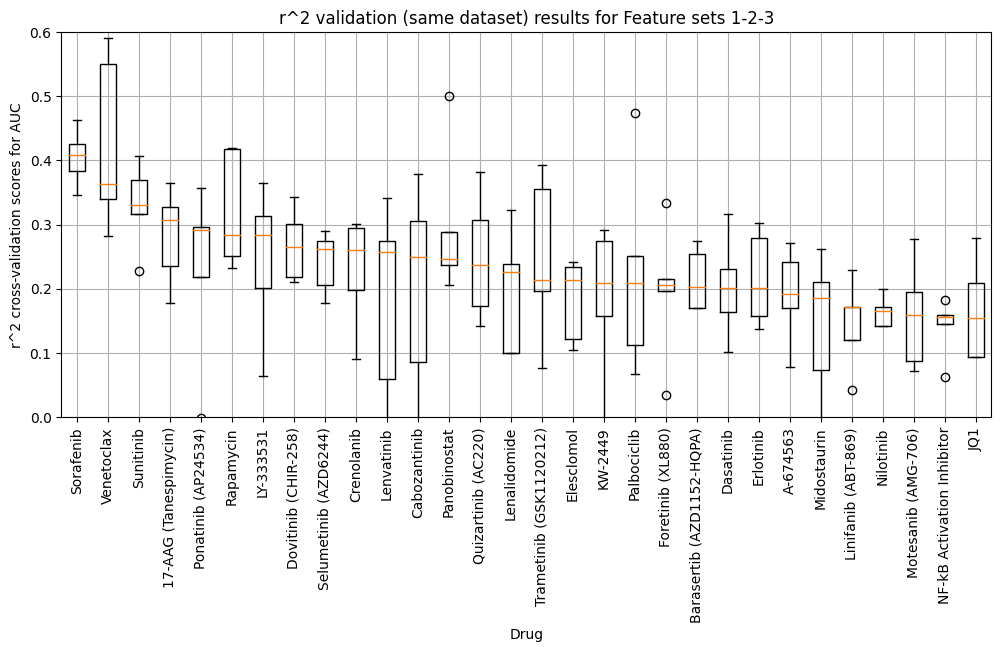

In [74]:
# TODO: add Feature sets 1 and 2 alone to this. Include train and val. See Figure 5 in the paper.
plt.figure(figsize=(12, 5))
plt.boxplot(f123_r2[indices_nonzero[:30]].tolist(), labels=drugs[indices_nonzero[:30]])
plt.xticks(rotation=90)
plt.ylim(0, 0.6)
plt.title('r^2 validation (same dataset) results for Feature sets 1-2-3')
plt.ylabel('r^2 cross-validation scores for AUC')
plt.xlabel('Drug')
plt.grid()
plt.show()

In [75]:
# create combined result table for rows 
combined_result_table = []
for drug in drugs:
    f4_drug_table = f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    #f3a_drug_table = f3a_coef[drug]
    #f3a_drug_table['features'] = 'F3a'
    #combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    f3b_drug_table = f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])
    f123_drug_table = f123_coef[f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features']])


In [76]:
combined_result_table = pd.concat(combined_result_table, axis=0)

In [77]:
drug_means = combined_result_table.groupby(['target']).aggregate('mean')

/tmp/ipykernel_395225/2102565793.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  drug_means = combined_result_table.groupby(['target']).aggregate('mean')


In [78]:
top_drugs = drug_means.sort_values('r2_score_test', ascending=False).index[:30]

In [79]:
import seaborn as sns

In [80]:
results_top_drugs = combined_result_table[combined_result_table.target.isin(top_drugs)]

In [81]:
results_top_drugs

,target,r2_score_train,r2_score_test,features
0,17-AAG (Tanespimycin),0.635687,0.448200,F4
1,17-AAG (Tanespimycin),0.769333,0.492687,F4
2,17-AAG (Tanespimycin),0.841324,0.293033,F4
3,17-AAG (Tanespimycin),0.712040,0.359379,F4
4,17-AAG (Tanespimycin),0.781669,0.354959,F4
...,...,...,...,...
585,Venetoclax,0.717556,0.282838,F1-2-3
586,Venetoclax,0.747590,0.590239,F1-2-3
587,Venetoclax,0.707121,0.550114,F1-2-3
588,Venetoclax,0.720000,0.363738,F1-2-3


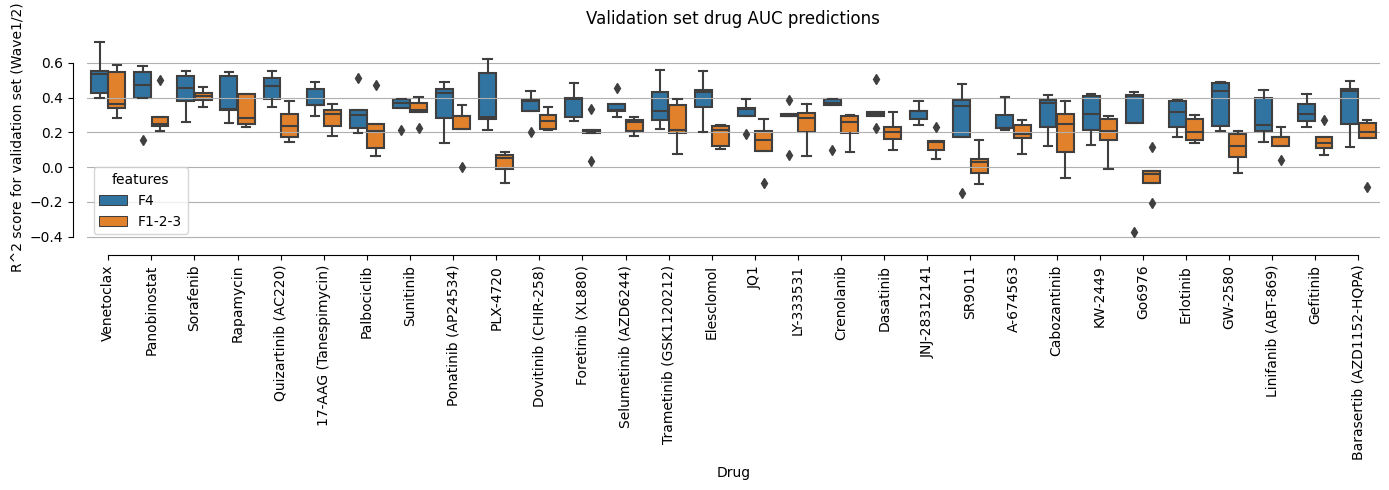

In [82]:
plt.figure(figsize=(14, 5))
results_top_drugs_f1234 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F1-2-3'])]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f1234, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Validation set drug AUC predictions')
plt.ylabel('R^2 score for validation set (Wave1/2)')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('validation_drug_auc_pred_features1234.png')

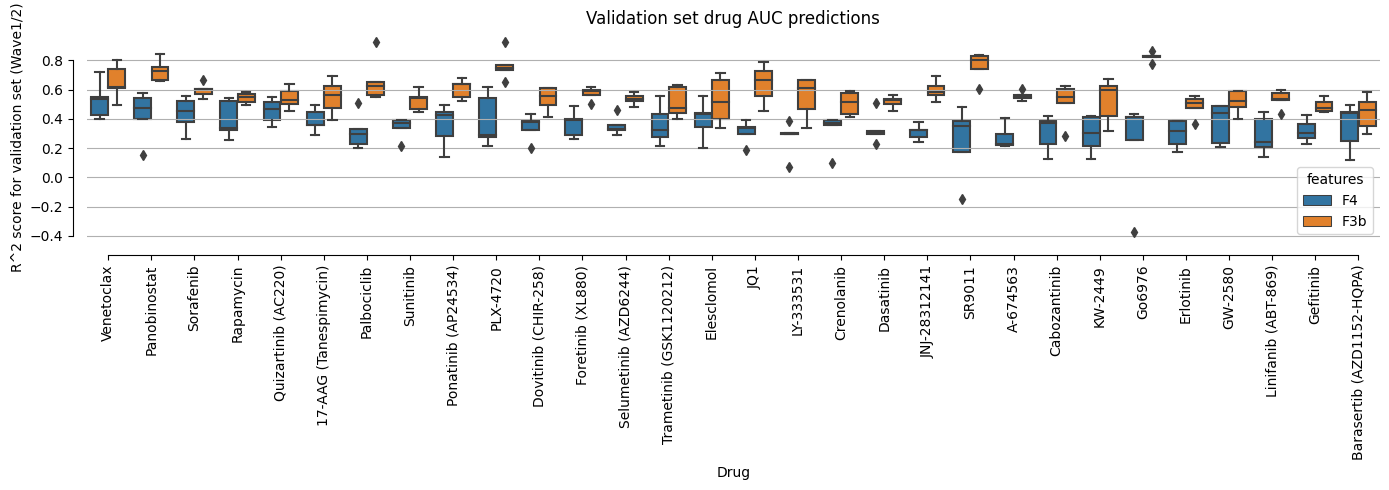

In [83]:
plt.figure(figsize=(14, 5))
results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F4', 'F3b'])]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Validation set drug AUC predictions')
plt.ylabel('R^2 score for validation set (Wave1/2)')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('validation_drug_auc_pred_features3b4.png')

## 5. Load test data

### Load RPKM and drug response data for wave3/4 (also includes wave1/2 data, have to filter these out)

In [84]:
all_drug_response = pd.read_csv('data/beataml_probit_curve_fits_v4_distr_nonproprietary.txt', sep='\t')

In [85]:
all_drug_response

,lab_id,patient_id,inhibitor,min_conc,max_conc,intercept,beta,beta_z,beta_p,aic,...,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type,type,proprietary
0,11-00261,127,AKT Inhibitor IV,0.03430,25,-0.346985,-0.534891,-0.970573,0.331761,9.755566,...,0.034300,0.224542,4.095265,25.000000,109.414835,False,False,decreasing,no_replicate,Non-Proprietary
1,11-00261,127,AKT Inhibitor X,0.06860,50,0.397591,-0.113167,-0.221591,0.824632,10.877425,...,0.068600,50.000000,50.000000,50.000000,183.984149,True,False,decreasing,no_replicate,Non-Proprietary
2,11-00261,127,AMPK Inhibitor,0.01370,10,0.127463,-0.668620,-1.142479,0.253255,10.180482,...,0.152012,1.551084,10.000000,10.000000,183.478483,False,False,decreasing,no_replicate,Non-Proprietary
3,11-00261,127,AST-487,0.01370,10,0.892331,-0.631916,-0.858336,0.390707,6.645376,...,2.211724,10.000000,10.000000,10.000000,242.784602,True,False,decreasing,no_replicate,Non-Proprietary
4,11-00261,127,Alisertib (MLN8237),0.01370,10,0.580598,-0.821939,-1.137503,0.255328,8.073871,...,0.768719,5.085989,10.000000,10.000000,222.464333,False,False,decreasing,no_replicate,Non-Proprietary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78713,19-00465,5275,Vismodegib (GDC-0449),0.01370,10,11.338225,-9.798777,-0.000763,0.999391,4.127685,...,10.000000,10.000000,10.000000,10.000000,286.054744,True,False,decreasing,no_replicate,Non-Proprietary
78714,19-00465,5275,Volasertib (BI-6727),0.01370,10,-0.704943,-0.646073,-1.111532,0.266339,8.902190,...,0.013700,0.081074,0.897093,7.806963,101.568804,False,False,decreasing,no_replicate,Non-Proprietary
78715,19-00465,5275,XAV-939,0.01370,10,1.237588,-0.288334,-0.394796,0.692994,5.408943,...,10.000000,10.000000,10.000000,10.000000,259.803731,True,False,decreasing,no_replicate,Non-Proprietary
78716,19-00465,5275,XMD 8-87,0.01370,10,-0.263175,0.083194,0.164553,0.869296,11.602969,...,0.013700,0.013700,10.000000,10.000000,109.579679,False,True,increasing,no_replicate,Non-Proprietary


In [86]:
all_drugs = all_drug_response.inhibitor.unique()

In [87]:
all_samples = all_drug_response.lab_id.unique()

In [88]:
data_train_test = pd.read_csv('data/beataml_waves1to4_allnorm.txt', sep = '\t')

In [89]:
data_train_test

,stable_id,display_label,description,biotype,13-00098,13-00342,13-00353,13-00466,13-00468,13-00500,...,19-00165,19-00179,19-00315,19-00332,19-00334,19-00400,18-00179,19-00092,19-00200,19-00261
0,ENSG00000000003,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],protein_coding,-2.962154,-0.523606,-0.586891,1.757141,-1.916265,-0.210697,...,-1.558306,-2.606667,-0.520126,-2.779703,-1.052378,-2.082540,0.347735,-1.548321,-0.059579,-2.413833
1,ENSG00000000419,DPM1,dolichyl-phosphate mannosyltransferase polypep...,protein_coding,8.289174,7.995268,8.371270,8.634921,7.977138,8.254783,...,7.856388,8.451163,7.310249,7.948950,8.133486,7.783736,8.031471,8.162220,8.059582,7.984738
2,ENSG00000000457,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,protein_coding,4.474460,4.390956,4.905668,5.205251,4.735073,4.357139,...,5.047697,4.950124,5.631029,4.874319,5.084156,4.620622,5.204472,4.660469,4.932784,4.505005
3,ENSG00000000460,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,protein_coding,5.181530,4.036060,4.105971,2.499966,3.743923,4.133550,...,4.540818,4.026929,2.710747,3.822684,4.431313,3.495374,4.386567,5.137836,4.017847,4.211124
4,ENSG00000000938,FGR,feline Gardner-Rasheed sarcoma viral oncogene ...,protein_coding,5.057466,7.143521,10.197801,9.425625,10.700992,7.336921,...,11.134967,11.515788,8.003741,10.178326,11.405671,9.320682,5.089631,7.908591,8.078920,9.949064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23145,ENSG00000273477,RP11-196O16.1,NaN,lincRNA,1.912212,3.480229,-0.052933,-0.862427,0.652092,2.082047,...,-1.641834,0.969974,3.682247,1.420943,2.513853,2.035861,3.563247,1.811217,2.163361,3.264825
23146,ENSG00000273483,RP4-671G15.2,NaN,antisense,-1.651524,1.046215,1.003326,1.582908,1.064976,-0.183531,...,-1.320587,1.246771,0.188252,1.364116,1.118926,0.419354,1.949921,0.722911,1.897334,0.115704
23147,ENSG00000273486,RP11-731C17.2,NaN,antisense,4.318339,4.715502,3.477559,3.513844,3.470215,4.877941,...,4.761862,4.086616,4.764841,5.176542,4.360157,5.180014,3.884189,5.621294,4.454744,4.348569
23148,ENSG00000273487,RP4-621B10.8,NaN,lincRNA,-1.017907,-2.163464,-0.027850,0.767219,-0.594899,0.780320,...,-2.122510,0.366889,1.070602,0.852974,1.864730,0.691136,1.197564,-0.457598,1.824112,0.439891


In [90]:
data_train_test.index = data_train_test.stable_id

In [91]:
included_genes

Gene
ENSG00000000419             DPM1
ENSG00000000457            SCYL3
ENSG00000000460         C1orf112
ENSG00000000938              FGR
ENSG00000000971              CFH
                       ...      
ENSG00000273464    RP11-313P22.1
ENSG00000273466     RP11-548H3.1
ENSG00000273477    RP11-196O16.1
ENSG00000273486    RP11-731C17.2
ENSG00000273488     RP11-114I8.4
Name: Symbol, Length: 17691, dtype: object

In [92]:
for gene_index in included_genes.index:
    if gene_index not in data_train_test.index:
        data_train_test.loc[gene_index] = 0

#### Getting sample IDs for wave3-4 (all sample IDs that are not in wave1-2)

In [93]:
wave12_samples = rpkm_t.index[2:]

In [94]:
wave34_samples = data_train_test.columns[4:].difference(wave12_samples)

In [95]:
len(wave34_samples)

256

In [96]:
wave34_rpkm = data_train_test.loc[:, list(wave34_samples)]

In [97]:
wave34_drug_response = all_drug_response[all_drug_response.lab_id.isin(wave34_samples)]

In [98]:
print(len(wave34_drug_response))

26719


In [99]:
wave34_drug_response = wave34_drug_response[wave34_drug_response.inhibitor.isin(drugs)]

In [100]:
print(len(wave34_drug_response))

18123


In [101]:
wave34_drug_response[wave34_drug_response.inhibitor == 'Venetoclax']

,lab_id,patient_id,inhibitor,min_conc,max_conc,intercept,beta,beta_z,beta_p,aic,...,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type,type,proprietary
44394,16-00834,4037,Venetoclax,0.0137,10,0.603517,-2.998159e-01,-5.312788e-01,0.595226,7.948328,...,0.579803,10.000000,10.000000,10.000000,2.180355e+02,True,False,decreasing,no_replicate,Non-Proprietary
45616,16-00980,4082,Venetoclax,0.0137,10,-0.173868,-5.377198e-01,-9.956142e-01,0.319438,9.973360,...,0.026443,0.474961,8.530902,10.000000,1.492106e+02,False,False,decreasing,no_replicate,Non-Proprietary
50392,17-00021,4324,Venetoclax,0.0137,10,0.612925,-3.001834e-01,-5.304470e-01,0.595802,8.897077,...,0.623603,10.000000,10.000000,10.000000,2.188516e+02,True,False,decreasing,no_replicate,Non-Proprietary
50550,17-00025,4325,Venetoclax,0.0137,10,0.553981,-4.003512e-01,-6.947995e-01,0.487181,8.675643,...,0.500025,10.000000,10.000000,10.000000,2.160664e+02,True,False,decreasing,no_replicate,Non-Proprietary
50710,17-00033,4359,Venetoclax,0.0137,10,-0.416605,-2.020824e-01,-3.943128e-01,0.693350,10.634845,...,0.013700,0.013700,10.000000,10.000000,1.067003e+02,False,True,decreasing,no_replicate,Non-Proprietary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76937,19-00315,5213,Venetoclax,0.0137,10,-1.467811,-4.299869e-01,-5.913373e-01,0.554294,5.814528,...,0.013700,0.013700,0.014288,0.368829,3.256200e+01,False,True,decreasing,no_replicate,Non-Proprietary
77103,19-00327,5218,Venetoclax,0.0137,10,-0.342786,-1.612092e+00,-1.596679e+00,0.110337,6.375205,...,0.233868,0.612830,1.606155,3.822325,1.645453e+02,False,False,decreasing,no_replicate,Non-Proprietary
77277,19-00332,5013,Venetoclax,0.0137,10,-0.056360,-6.921396e-01,-1.199506e+00,0.230331,8.928203,...,0.087917,0.829088,7.817563,10.000000,1.667526e+02,False,False,decreasing,no_replicate,Non-Proprietary
77443,19-00334,4989,Venetoclax,0.0137,10,0.886075,-9.570518e-01,-1.057500e+00,0.290283,7.128204,...,1.663720,8.430262,10.000000,10.000000,2.409528e+02,False,False,decreasing,no_replicate,Non-Proprietary


### Get mutation features for test data

In [102]:
wave34_mutation = pd.read_csv('data/BeatAML_mut_matrix_sele_w3_4.csv', index_col=0)

In [103]:
wave34_mutation.head()

,NPM1,CEBPA,STAG2,SF3B1,PTPN11,TP53,BCOR,RUNX1,FLT3,SRSF2,...,DNMT3A,WT1,GATA2,EZH2,ASXL1,NRAS,IDH1,U2AF1,TET2,IDH2
16-00358,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
18-00039,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
19-00035,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
19-00418,0,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
17-00937,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# re-order the genes to be the same order as wave1-2
wave34_mutation = wave34_mutation.loc[:, highly_mutated_genes]

In [105]:
wave34_mutation.shape

(268, 22)

In [106]:
wave34_mutation_freq = pd.read_csv('data/BeatAML_w3_4_vaf_matrix_sele.csv', index_col=0)

In [107]:
wave34_mutation_freq.head()

,IDH1p.R132C,FLT3p.A680V,JAK2p.V617F,KRASp.G12D,NPM1p.W288Cfs*12,ASXL1p.G645Vfs*58,NRASp.G13D,SF3B1p.K666N,ASXL1p.G646Wfs*12,NRASp.G12D,...,DNMT3Ap.R882C,SRSF2p.P95R,SF3B1p.K700E,U2AF1p.Q157P,DNMT3Ap.R882H,FLT3p.D835Y,NRASp.Q61K,FLT3p.D835H,U2AF1p.S34F,NRASp.Q61H
16-00358,0.0,0.0,0.412935,0.0,0.210526,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
18-00039,0.0,0.0,0.000000,0.0,0.172414,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.532934,0.0,0.0,0.0,0.0,0.0
19-00035,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.371795,0.355049,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
19-00418,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17-00937,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.122363,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [108]:
for allele in variant_alleles:
    if allele not in wave34_mutation_freq.columns:
        wave34_mutation_freq.loc[:, allele] = 0
wave34_mutation_freq = wave34_mutation_freq.loc[:, variant_alleles]

In [109]:
wave34_mutation_freq.shape

(239, 28)

### Creating feature set tables with a defined set of patient samples

In [110]:
# convert this to a numpy array indexed by patient
data_rows = []
for sample in wave34_samples:
    if sample not in wave34_mutation.index:
        row = np.zeros(len(highly_mutated_genes))
    else:
        row = wave34_mutation.loc[sample, ]
    data_rows.append(row)
data_rows = np.array(data_rows)
wave34_feature_set_1_table = pd.DataFrame(data_rows)
wave34_feature_set_1_table.index = wave34_samples
wave34_feature_set_1_table.columns = wave34_mutation.columns

In [111]:
wave34_feature_set_1_table

,TET2,STAG2,RUNX1,EZH2,JAK2,FLT3,SF3B1,GATA2,WT1,CEBPA,...,IDH1,BCOR,TP53,ASXL1,DNMT3A,U2AF1,PTPN11,SRSF2,NRAS,IDH2
00-00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19-00327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19-00332,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19-00334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
19-00369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# convert this to a numpy array indexed by patient
data_rows = []
for sample in wave34_samples:
    if sample not in wave34_mutation_freq.index:
        row = np.zeros(len(variant_alleles))
    else:
        row = wave34_mutation_freq.loc[sample, ]
    data_rows.append(row)
data_rows = np.array(data_rows)
wave34_feature_set_2_table = pd.DataFrame(data_rows)
wave34_feature_set_2_table.index = wave34_samples
wave34_feature_set_2_table.columns = wave34_mutation_freq.columns

In [113]:
wave34_feature_set_2_table

,FLT3p.A680V,FLT3p.I836del,FLT3p.D835Y,FLT3p.D835H,NRASp.G13D,NRASp.Q61H,NRASp.Q61K,NRASp.G13R,NRASp.G12D,KRASp.G12D,...,ASXL1p.G646Wfs*12,ASXL1p.G645Vfs*58,SF3B1p.K666N,SF3B1p.K700E,NPM1p.W288Cfs*12,JAK2p.V617F,SRSF2p.P95H,SRSF2p.P95L,SRSF2p.P95R,SRSF2p.P95_R102del
00-00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
00-00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
00-00004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
00-00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
00-00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19-00327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.378378,0.0,0.000000,0.0,0.0,0.0
19-00332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.522293,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
19-00334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.295455,0.0,0.000000,0.0,0.0,0.0
19-00369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


### Filtering and normal-scaling the test RPKM matrix

(Warning: this is not actually the same scaler as the training data - the training data was already normalized by z-score, so this is a separate normalization.)

In [114]:
import pickle as pkl

In [115]:
wave34_rpkm_filtered = wave34_rpkm.loc[included_genes.index].T

In [116]:
with open('models/rpkm_scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)
data_scaled_filtered = scaler.fit_transform(wave34_rpkm_filtered.values)

In [117]:
wave34_rpkm_scaled_filtered = wave34_rpkm_filtered.copy()
wave34_rpkm_scaled_filtered[:] = data_scaled_filtered

In [118]:
wave34_rpkm_scaled_filtered.mean(0)

Gene
ENSG00000000419    6.552051e-15
ENSG00000000457   -1.540434e-15
ENSG00000000460    1.614160e-15
ENSG00000000938    3.851086e-16
ENSG00000000971   -1.804112e-16
                       ...     
ENSG00000273464   -2.636780e-16
ENSG00000273466   -2.123302e-15
ENSG00000273477   -2.775558e-16
ENSG00000273486    2.123302e-15
ENSG00000273488   -4.857226e-17
Length: 17691, dtype: float64

In [119]:
wave34_rpkm_scaled_filtered.std(0)

Gene
ENSG00000000419    1.001959
ENSG00000000457    1.001959
ENSG00000000460    1.001959
ENSG00000000938    1.001959
ENSG00000000971    1.001959
                     ...   
ENSG00000273464    1.001959
ENSG00000273466    1.001959
ENSG00000273477    1.001959
ENSG00000273486    1.001959
ENSG00000273488    1.001959
Length: 17691, dtype: float64

### Get KG-based features for test data

In [120]:
from kgfe import gene_names
def generate_drug_graph_features_wave34(drugs, expression, KG_reg, drug_coefficients, housekeeping_genes):
    """
    Args:
        drugs - a list of drug names
        expression - a gene expression table, with genes on axis 0 and samples on axis 1
        KG_reg: regulatory knowledge graph
        drug_coefficients:
        housekeeping_genes: a list of housekeeping gene names
    
    Returns:
        drug_data_outputs: a dict of drug name to pandas dataframe
    """
    drug_data_outputs = {}
    housekeeping_genes_ensembl = gene_names.convert('symbol', 'ensembl', housekeeping_genes)
    temp_expression = expression.copy()
    housekeeping_gene_expression = temp_expression.loc[housekeeping_genes_ensembl]
    for drug in drugs:
        coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
        output_features = []
        print(drug, len(coefficients), 'gene coefficients')
        feature_names = []
        for _, row in coefficients.iterrows():
            gene = row['Gene']
            symbol = row['Symbol']
            if gene in temp_expression.index:
                expression_data = temp_expression.loc[gene]
                # generate features for regulatory genes
                if gene in KG_reg.index:
                    regulators = KG_reg.loc[gene]
                    # only include negative regulators?
                    regulators = regulators[regulators.Coef < 0]
                    for reg_gene in regulators.Regulator:
                        try:
                            reg_gene_ensembl = gene_names.convert('symbol', 'ensembl', [reg_gene])[0]
                            reg_expr = temp_expression.loc[reg_gene_ensembl]
                            ratios = expression_data/reg_expr
                            ratios[ratios >= 1] = 1
                            ratios[ratios < 1] = 0
                            feature_names.append(symbol + '_' + reg_gene)
                            output_features.append(ratios)
                        except:
                            pass
                # generate features for housekeeping genes
                for h_gene_symbol, h_gene in zip(housekeeping_genes, housekeeping_genes_ensembl):
                    h_gene_expr = housekeeping_gene_expression.loc[h_gene]
                    ratios = expression_data/h_gene_expr
                    ratios[ratios >= 1] = 1
                    ratios[ratios < 1] = 0
                    feature_names.append(symbol + '_' + h_gene_symbol)
                    output_features.append(ratios)
        print('features:', len(feature_names))
        drug_data_outputs[drug] = pd.concat(output_features, axis=1)
        drug_data_outputs[drug].columns = feature_names
    return drug_data_outputs

In [121]:
%time wave34_drugs_feature4 = generate_drug_graph_features_wave34(drugs, wave34_rpkm, KG_reg, drug_coefficients, housekeeping_genes)

17-AAG (Tanespimycin) 62 gene coefficients
features: 1186
A-674563 60 gene coefficients
features: 1093
ABT-737 55 gene coefficients
features: 996
AT7519 57 gene coefficients
features: 1008
AZD1480 57 gene coefficients
features: 1009
Afatinib (BIBW-2992) 51 gene coefficients
features: 925
Alisertib (MLN8237) 44 gene coefficients
features: 781
Axitinib (AG-013736) 60 gene coefficients
features: 1111
BEZ235 50 gene coefficients
features: 869
BI-2536 58 gene coefficients
features: 1029
BMS-345541 52 gene coefficients
features: 907
Barasertib (AZD1152-HQPA) 49 gene coefficients
features: 907
Bay 11-7085 58 gene coefficients
features: 1039
Bortezomib (Velcade) 64 gene coefficients
features: 1143
Bosutinib (SKI-606) 55 gene coefficients
features: 978
CHIR-99021 52 gene coefficients
features: 941
CI-1040 (PD184352) 59 gene coefficients
features: 1063
CYT387 64 gene coefficients
features: 1130
Cabozantinib 57 gene coefficients
features: 1082
Canertinib (CI-1033) 59 gene coefficients
features: 1

In [122]:
wave34_drugs_feature4['Venetoclax']

,CLASP1_AHR,CLASP1_CEBPD,CLASP1_CLOCK,CLASP1_POU2F2,CLASP1_ZFHX3,CLASP1_RPS10,CLASP1_FNTA,CLASP1_COX6A1,CLASP1_BECN1,CLASP1_SF3B2,...,CASC15_PSMB2,CASC15_AUP1,CASC15_SRP14,CASC15_HNRNPK,CASC15_CCNI,CASC15_RHOA,CASC15_PABPC1,CASC15_RPS11,CASC15_TPT1,CASC15_FTL
00-00002,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00003,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00004,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00005,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-00006,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19-00327,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19-00332,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19-00334,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19-00369,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6. Run test analyses

### Test analysis function

In [123]:
# Note: for each model, this runs it on the entire wave3/4 data, not just a subset.
def run_test_analyses(X, analyses, dependent_vars, 
                 return_params=False, labels=None,
                 save_model_prefix=''):
    """
    X - input data
    analyses - list of string (names of the analyses)
    dependent_var - list of arrays (things to test)
    model - a scikit-learn model
    
    return_params - whether or not to return the model parameters for each CV run. only for linear models.
    labels - list or array of labels for each of the covariates (required when saving the model parameters)

    save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    weights_results = []
    predicted_values = []
    predicted_r2_values = []
    for analysis, var in zip(analyses, dependent_vars):
        cv_score = []
        included_subset = (~np.isnan(var))
        X_new = X[included_subset]
        var = var[included_subset]
        if len(var) < 5:
            print('FAIL!')
            continue
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                with open(filename, 'rb') as f:
                    model = pickle.load(f)
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                weights.append(analysis)
                predictions = model.predict(X_new)
                score = r2_score(var, predictions)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                cv_round += 1
            all_cv_scores.append(cv_score)
            print(analysis)
            print('test r^2 scores:', cv_score, np.mean(cv_score))
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        columns = list(labels)
        if hasattr(model, 'intercept_'):
            columns.append('intercept')
        if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
            columns.append('alpha')
        df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_test'])
        return all_cv_scores, df
    else:
        return all_cv_scores

In [124]:
def run_test_analyses_feature4(X_analyses, analyses, dependent_vars, 
                 return_params=False, labels=None,
                 save_model_prefix=''):
    """
    X_analyses - input data
    analyses - list of string (names of the analyses)
    dependent_var - list of arrays (things to test)
    model - a scikit-learn model
    
    return_params - whether or not to return the model parameters for each CV run. only for linear models.
    labels - list or array of labels for each of the covariates (required when saving the model parameters)

    save_model_prefix - filename prefix for the models (could include a path).
    """
    all_cv_scores = []
    all_train_cv_scores = []
    cv = KFold(5, shuffle=True, random_state=0)
    predicted_values = []
    predicted_r2_values = []
    dfs = {}
    for analysis, var in zip(analyses, dependent_vars):
        weights_results = []
        cv_score = []
        included_subset = (~np.isnan(var))
        if callable(X_analyses):
            X_new = X_analyses(analysis)
        else:
            X_new = X_analyses[analysis]
        if isinstance(X_new, pd.DataFrame):
            column_names = X_new.columns
            X_new = X_new.to_numpy()
        else:
            column_names = labels
        X_new = X_new[included_subset]
        var = var[included_subset]
        if len(var) < 5:
            print('FAIL!')
            continue
        if return_params:
            cv_score = []
            cv_round = 0
            for train_index, test_index in cv.split(X_new, var):
                filename = save_model_prefix + '_' + analysis + '_fold' + str(cv_round) + '.pkl'
                with open(filename, 'rb') as f:
                    model = pickle.load(f)
                if hasattr(model, 'coef_'):
                    weights = list(model.coef_)
                elif hasattr(model, 'feature_importances_'):
                    weights = list(model.feature_importances_)
                if hasattr(model, 'intercept_'):
                    weights.append(model.intercept_)
                if hasattr(model, 'alpha'):
                    weights.append(model.alpha)
                elif hasattr(model, 'alpha_'):
                    weights.append(model.alpha_)
                weights.append(analysis)
                predictions = model.predict(X_new)
                score = r2_score(var, predictions)
                weights.append(score)
                cv_score.append(score)
                weights_results.append(weights)
                cv_round += 1
            columns = list(column_names)
            if hasattr(model, 'intercept_'):
                columns.append('intercept')
            if hasattr(model, 'alpha') or hasattr(model, 'alpha_'):
                columns.append('alpha')
            all_cv_scores.append(cv_score)
            print(analysis)
            print('test r^2 scores:', cv_score, np.mean(cv_score))
            df = pd.DataFrame(weights_results, columns=columns + ['target', 'r2_score_test'])
            dfs[analysis] = df
        else:
            cv_score = cross_val_score(model, X_new, var, cv=cv, scoring='r2')
            all_cv_scores.append(cv_score)
            print(analysis, cv_score, np.mean(cv_score))
    if return_params:
        return all_cv_scores, dfs
    else:
        return all_cv_scores

### Building the test set

In [125]:
dependent_vars = []
for drug in drugs:
    drug_subset = wave34_drug_response[wave34_drug_response.inhibitor==drug]
    drug_subset.index = drug_subset.lab_id
    drug_auc_vals = []
    for s in wave34_samples:
        try:
            d = drug_subset.loc[s]
            drug_auc_vals.append(d.auc)
        except:
            drug_auc_vals.append(np.nan)
    dependent_vars.append(np.array(drug_auc_vals))

### Feature set 1

In [126]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

import xgboost


In [127]:
X = wave34_feature_set_1_table.to_numpy()

In [128]:
wave34_f1_r2, wave34_f1_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=feature_set_1_table.columns,
                              save_model_prefix='models/feature1/f1_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [-0.12926736129362593, -0.1673478441061238, -0.1262775603978037, -0.1472265381041944, -0.15908382920685482] -0.14584062662172054
A-674563
test r^2 scores: [-0.8642557397158874, -0.675543571707659, -0.8079930933816275, -0.6994477459620607, -0.853713349572329] -0.7801907000679128
FAIL!
AT7519
test r^2 scores: [-0.042932308717097856, -0.027042978920671645, -0.04587676765768367, -0.022889291474927465, 0.011749680717158095] -0.025398333210644507
AZD1480
test r^2 scores: [-0.06326443368416257, -0.07545848891881746, -0.020152527459022407, -0.02543760873957468, -0.1170070183175218] -0.06026401542381978
Afatinib (BIBW-2992)
test r^2 scores: [-0.1866297564933943, -0.12900713987631618, -0.09100095075648085, -0.12034843702939768, -0.0988869996420001] -0.12517465675951783
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.07964912783190048, -0.06691031989439766, -0.031597744408642825, -0.10666955845963821] -0.06356620941125475
Axitinib (AG-013736)


In [129]:
wave34_f1_coef['model'] = 'lassocv'
wave34_f1_coef.to_csv('wave34_results/feature1_lassocv_coefs.csv', index=None)

### Feature set 2

In [130]:
X = wave34_feature_set_2_table.to_numpy()
wave34_f2_r2, wave34_f2_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=feature_set_2_table.columns,
                              save_model_prefix='models/feature2/f2_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [-0.054058725194812585, -0.0582202722071008, -0.036347458844733005, -0.02226050421647674, -0.04662076022856776] -0.04350154413833818
A-674563
test r^2 scores: [-0.5917170687663804, -0.5151851248411208, -0.554695261730968, -0.5449869164576453, -0.5693200252858275] -0.5551808794163884
FAIL!
AT7519
test r^2 scores: [-0.046744453654113505, -0.035800186507648935, -0.047385800674199396, -0.037115755436486486, -0.008056482302131407] -0.035020535714915944
AZD1480
test r^2 scores: [-0.0766882433678342, -0.0012289433896843782, -0.04754934680660816, -0.004370669146271489, -0.006544285968155483] -0.02727629773571074
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.11617910753930283, -0.07820730155565037, -0.05729589660814449, -0.0985962503359199] -0.08895581939833193
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.05515304668517107, -0.03210904297941353, -0.031597744408642825, -0.044791713812030176] -0.039331168869390434
Axitinib

In [131]:
wave34_f2_coef['model'] = 'lassocv'
wave34_f2_coef.to_csv('wave34_results/feature2_lassocv_coefs.csv', index=None)

### Feature set 1/2

In [132]:
X1 = wave34_feature_set_1_table.to_numpy()
X2 = wave34_feature_set_2_table.to_numpy()
X = np.hstack([X1, X2])
wave34_f12_r2, wave34_f12_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns]),
                              save_model_prefix='models/feature1_2/f1_2_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [-0.13833531652618758, -0.1573020026395071, -0.12557113655845886, -0.14571258879831905, -0.1559304661146741] -0.14457030212742933
A-674563
test r^2 scores: [-0.8204070492433468, -0.7340981419865431, -0.7913154997290988, -0.7101429737053224, -0.872177919954741] -0.7856283169238104
FAIL!
AT7519
test r^2 scores: [-0.046744453654113505, -0.028121148157121745, -0.04171159431680249, -0.022809270160287554, 0.011555721193721391] -0.02556614901892078
AZD1480
test r^2 scores: [-0.16471684699967204, -0.07229510374880821, -0.0188809022975307, -0.03770875001722529, -0.10837765635247076] -0.0803958518831414
Afatinib (BIBW-2992)
test r^2 scores: [-0.18486658633494124, -0.12900713987631618, -0.09100095075648085, -0.10633432189312142, -0.0988869996420001] -0.12201919970057196
Alisertib (MLN8237)
test r^2 scores: [-0.03300429646169456, -0.08229287846451339, -0.07024356871612514, -0.031597744408642825, -0.08689888797805856] -0.06080747520580689
Axitinib (AG-013736)


In [133]:
wave34_f12_coef['model'] = 'lassocv'
wave34_f12_coef.to_csv('wave34_results/feature1_2_lassocv_coefs.csv', index=None)

### Feature set 3

In [134]:
X = wave34_rpkm_scaled_filtered.values
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f3_r2, wave34_f3_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=rpkm_scaled_filtered.columns,
                              save_model_prefix='models/feature3/f3_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.17506596752504888, 0.12208680122317495, 0.21536288938573844, 0.11595647217801375, 0.18311434831172801] 0.1623172957247408
A-674563
test r^2 scores: [-0.5938565344949958, -0.43586074868489555, -0.5051937413649155, -0.683763014604633, -0.527237043424976] -0.5491822165148832
FAIL!
AT7519
test r^2 scores: [0.02531327734455513, 0.10788434309344408, 0.06407898095404163, 0.047918769918072535, 0.007649349164434827] 0.05056894409490964
AZD1480
test r^2 scores: [-0.043402303654736185, -0.045030430317723136, -0.02713290272695046, -0.0002980422947338468, -0.013301214298669484] -0.02583297865856262
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.13425768244554837, -0.09100095075648085, -0.014812070478456896, -0.0988869996420001] -0.08669164885502564
Alisertib (MLN8237)
test r^2 scores: [-0.042884822671945155, -0.042261437656780476, -0.029376977849849606, -0.06068194103454716, -0.0416484910536945] -0.04337073405336338
Axitinib (AG-013736)
tes

In [135]:
wave34_f3_coef['model'] = 'lassocv'
wave34_f3_coef.to_csv('wave34_results/feature3_lassocv_coefs.csv', index=None)

### Feature set 3a (important genes only, genes with at least one nonzero coefficient from LASSO for the given drug)

In [136]:
def wave34_get_f3_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    subset = f3_coef[f3_coef.target == drug]
    # get nonzero genes
    subset_genes = subset.iloc[:, :-6]
    included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return wave34_rpkm_scaled_filtered
    return data_subset

In [137]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f3a_r2, wave34_f3a_coef = run_test_analyses_feature4(wave34_get_f3_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature3a/f3a_lassocv')

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

17-AAG (Tanespimycin)
test r^2 scores: [-0.021133530087285912, -0.027174449816204094, -0.005991370179148969, -0.14672069542795474, -0.0064696630484391005] -0.04149794171180656
A-674563
test r^2 scores: [-0.9642957216689669, -0.7066542660800867, -0.7339073794697337, -1.1563173372798796, -0.8801765087513114] -0.8882702426499958
FAIL!
AT7519
test r^2 scores: [0.02071314512639766, -0.020868820647087283, -0.008940073369376522, 0.016806264225402767, 0.03336552866530873] 0.00821520880012907
AZD1480
test r^2 scores: [-0.2366374512538545, -0.25248324262211885, -0.1814261453486885, -0.22701297933886377, -0.14654323284574566] -0.20882061028185425
Afatinib (BIBW-2992)
test r^2 scores: [-0.1313925417103463, -0.2513519790387928, -0.1461774995087115, -0.17621125464203335, -0.19005065860788894] -0.1790367867015546
Alisertib (MLN8237)
test r^2 scores: [-0.3632181660060081, -0.26207112962268675, -0.17442924603349552, -0.31748808332836953, -0.2007475829821208] -0.26359084159453616
Axitinib (AG-013736)
te

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

DBZ
test r^2 scores: [-0.10615150620828917, -0.1223519175940504, -0.03235357355348367, 0.0402447825442932, -0.077638910757305] -0.05965022511376701
Dasatinib
test r^2 scores: [-0.030414796054662796, 0.0388311359096325, 0.06569119092968811, 0.08275898562343975, 0.06551379496431031] 0.04447606227448157
Doramapimod (BIRB 796)
test r^2 scores: [0.03921598382739466, -0.08439181207933233, 0.04000653825707623, 0.00925423579267104, -0.2219451577137863] -0.04357204238319534
Dovitinib (CHIR-258)
test r^2 scores: [0.10517116980736152, 0.06296492204659532, 0.09537851335590408, 0.08790324499231439, 0.002159128475024752] 0.07071539573544001
Elesclomol
test r^2 scores: [0.1560479583733977, 0.17762261444944005, 0.24150048140441494, 0.14146896797448805, 0.15050581364343818] 0.17342916716903578
Entospletinib (GS-9973)
test r^2 scores: [-0.2968972630816362, -0.5042645129832299, -0.16934005744843383, -0.07206520436210573, -0.7224743923945856] -0.35300828605399825


/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Entrectinib
test r^2 scores: [-0.0500757165684258, -0.13174712935410904, -0.24234097103099694, -0.13188147667153882, -0.07642952666086722] -0.12649496405718758
Erlotinib
test r^2 scores: [0.021809982067408695, 0.02412196840126435, 0.015731082631529225, 0.048172418277964923, -0.07742674406094374] 0.00648174146344469
Flavopiridol
test r^2 scores: [-0.4286423384663076, -0.46499299215803425, -0.5162288975678311, -0.6376892234330591, -0.4546326232427307] -0.5004372149735925
Foretinib (XL880)
test r^2 scores: [-0.2505291516179948, -0.2882694694433807, -0.2396378270385522, -0.3385549036963973, -0.1551658505907072] -0.25443144047740646
GDC-0879
test r^2 scores: [-0.1279634216345913, -0.2085659133003499, -0.08303110884623477, -0.13442860516910127, -0.13336937957671036] -0.13747168570539753
GDC-0941
test r^2 scores: [-0.41818130657259456, -0.40950149342910236, -0.3460036067632659, -0.40893071211884324, -0.38605558899732406] -0.393734541576226
GSK-1838705A
test r^2 scores: [-0.3213879400200599, -

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

KI20227
test r^2 scores: [-0.21751428199468337, -0.2879619390764119, -0.22213076082113004, -0.08516890024199619, -0.4574599114089062] -0.25404715870862554
KU-55933
test r^2 scores: [-0.017200892259984224, 0.013301392935658796, -0.0013768269016360968, 0.011383873539743905, 0.026767642113360246] 0.006575037885428525
KW-2449
test r^2 scores: [0.07216731311886593, 0.06356143936230607, 0.1170658238419392, 0.10312274460726711, 0.12841110620475693] 0.09686568542702705
LY-333531
test r^2 scores: [0.0918347966030626, -0.010628948516912429, 0.0517735409697313, 0.08988858612450135, -0.018165887131132985] 0.04094041760984997
Lapatinib
test r^2 scores: [-0.37033705871012845, -0.5835852204776804, -0.3993261726047461, -0.48752182731571114, -0.4360941243823091] -0.455372880698115
Lenalidomide
test r^2 scores: [-0.2242092450329347, -0.15792327044644927, -0.019257178638724115, -0.02368358392649017, 0.03914660986483465] -0.07718533363595273
Lenvatinib
test r^2 scores: [-0.04279033314065095, -0.0050552218

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Neratinib (HKI-272)
test r^2 scores: [-0.018116072981666065, -0.04761984071791403, 0.0020258907151117223, 0.009165112302564116, -0.01620554297405663] -0.014150090731192177
Nilotinib
test r^2 scores: [-0.0710436507176182, -0.03806995459915097, -0.10334940559267958, -0.0884553851396408, -0.06689290295521655] -0.07356225980086122
Nutlin 3a
test r^2 scores: [-0.46529506203702176, -0.42729877783988224, -0.3857280513650625, -0.47567048346590024, -0.41208072353845093] -0.43321461964926355
PD173955
test r^2 scores: [-0.1290336267188017, -0.23441408442064304, -0.1886037980878994, -0.16006327464858772, -0.3008552649501792] -0.2025940097652222
PHA-665752
test r^2 scores: [0.011119566836932604, 0.01631429793709449, 0.022772160864399482, 0.011249131872184792, -0.06981918582804703] -0.0016728056634871314
PHT-427
test r^2 scores: [-0.1357424459096055, -0.18838496032471208, -0.23856190131665644, -0.1951771992997584, -0.0446549271872716] -0.16050428680760082
PI-103
test r^2 scores: [-0.0449993175195506

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and S

Roscovitine (CYC-202)
test r^2 scores: [-0.00365153146363717, -0.3241460644125844, -0.2103747988015927, -0.19664752706096023, -0.20380065196088637] -0.18772411473993217
Ruxolitinib (INCB018424)
test r^2 scores: [-0.2753619596024912, -0.2883067029292059, -0.27261043616750946, -0.3016894873490601, -0.31942332572518706] -0.29147838235469076
S31-201
test r^2 scores: [-0.08128025935934935, -0.062193618807945494, -0.036618598071952446, -0.09011184552018214, -0.18996869021761453] -0.0920346023954088
SB-431542
test r^2 scores: [-0.11743226345341662, -0.26140030590361274, -0.23897905954586274, -0.28484635394912794, -0.3329629840547397] -0.24712419338135194
SGX-523
test r^2 scores: [-0.13335858509118514, -0.09008259348149461, -0.1473629621283954, -0.13139488616156725, -0.17684374515832868] -0.1358085544041942
SNS-032 (BMS-387032)
test r^2 scores: [-0.5352424539438616, -0.4926725757366386, -0.4925181717429228, -0.6170361518385095, -0.4637284554778984] -0.5202395617479662
SR9011
test r^2 scores: [

/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


Vemurafenib (PLX-4032)
test r^2 scores: [-0.14260886392109318, -0.16653238338654264, -0.17632079616601093, -0.11489845703791879, -0.08802136652207015] -0.13767637340672714
Venetoclax
test r^2 scores: [0.4899513421597723, 0.40548647587939257, 0.4698036420912033, 0.43611638932968555, 0.4708131007993763] 0.45443419005188607
Vismodegib (GDC-0449)
test r^2 scores: [-0.04197589158684112, -0.025047620580341157, -0.03703524657949964, -0.04642199440192396, -0.05912617764088979] -0.04192138615789913
Volasertib (BI-6727)
test r^2 scores: [-0.0026040163315224074, -0.0029646134403813473, -6.035481808996934e-05, -0.0007952335887388973, -0.00022759126007754205] -0.0013303618877620327
XAV-939
test r^2 scores: [-0.8709102151070498, -0.8979146845471802, -0.8640272278707068, -0.9106539909054914, -0.9211353538067726] -0.8929282944474402
YM-155
test r^2 scores: [-0.17842122206989464, -0.06351039204698705, -0.09695467767897736, -0.10053512098485706, -0.24037822201039583] -0.1359599269582224


/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]
/tmp/ipykernel_395225/4101621131.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  included_genes = subset_genes.columns[(subset_genes != 0).any(0)]


In [138]:
for key, df in wave34_f3a_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3a/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b (genes from the file Supplemental_2_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv)

In [139]:
def wave34_get_f3b_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    if len(included_genes) == 0:
        return wave34_rpkm_scaled_filtered
    return data_subset

In [140]:
wave34_f3b_r2, wave34_f3b_coef = run_test_analyses_feature4(wave34_get_f3b_subset, drugs, dependent_vars,
                             return_params=True,
                              save_model_prefix='models/feature3b/f3b_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.13924666072231362, 0.07406984508501424, 0.14411328890792052, 0.10175260406646303, 0.15014625383942637] 0.12186573052422756
A-674563
test r^2 scores: [-0.6548939993088096, -0.6025943542270851, -0.6049869602971947, -0.5575214310623986, -0.5921210162071944] -0.6024235522205365
FAIL!
AT7519
test r^2 scores: [-0.025930157249079544, 0.005327724767419384, -0.06168257287878531, -0.08118671253337073, 0.03909409146317866] -0.02487552528612751
AZD1480
test r^2 scores: [-0.2522268029194603, -0.30360018801175204, -0.23301438255922924, -0.23801570537652594, -0.18292207447669173] -0.24195583066873186
Afatinib (BIBW-2992)
test r^2 scores: [-0.40631162025839074, -0.35938664014534627, -0.39570868382542934, -0.27080819864503614, -0.42728052745707523] -0.3718991340662555
Alisertib (MLN8237)
test r^2 scores: [-0.3117403661034135, -0.2426268143959669, -0.2570249757961778, -0.22463845911217795, -0.26530084608056503] -0.26026629229766024
Axitinib (AG-013736)
test r^2 

In [141]:
for key, df in wave34_f3b_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3b/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3

In [142]:
X1 = wave34_feature_set_1_table.to_numpy()
X2 = wave34_feature_set_2_table.to_numpy()
X3 = wave34_rpkm_scaled_filtered.to_numpy()
X = np.hstack([X1, X2, X3])
wave34_f123_r2, wave34_f123_coef = run_test_analyses(X, drugs, dependent_vars,
                              return_params=True,
                              labels=np.hstack([feature_set_1_table.columns, feature_set_2_table.columns, rpkm_scaled_filtered.columns]),
                              save_model_prefix='models/feature1_2_3/f123_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.16505025060140965, 0.12183267207590998, 0.21775288245981106, 0.11391175546250798, 0.17956871054440138] 0.15962325422880802
A-674563
test r^2 scores: [-0.6051046953663761, -0.4491066890802875, -0.5019371445951566, -0.6541042805029353, -0.5256746943854858] -0.5471855007860482
FAIL!
AT7519
test r^2 scores: [0.032136314632817076, 0.13105156369846316, 0.07026010306409891, 0.056628979175391114, 0.008482455466407246] 0.0597118832074355
AZD1480
test r^2 scores: [-0.03586956026075527, -0.04905020863009035, -0.03557710972551886, -0.0024003525568871975, -0.011524600460117496] -0.026884366326673837
Afatinib (BIBW-2992)
test r^2 scores: [-0.09450054095264204, -0.1332659960914595, -0.09100095075648085, -0.054576014094322334, -0.0988869996420001] -0.09444610030738096
Alisertib (MLN8237)
test r^2 scores: [-0.03734456058655122, -0.041442181494696806, -0.02150572608125012, -0.07067078346259792, -0.03879792496374157] -0.041952235317767525
Axitinib (AG-013736)
tes

In [143]:
wave34_f123_coef['model'] = 'lassocv'
wave34_f123_coef.to_csv('wave34_results/feature123_lassocv_coefs.csv', index=None)

### Feature set 4

In [144]:
wave34_f4_r2, wave34_f4_coef = run_test_analyses_feature4(wave34_drugs_feature4, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature4/f4_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.18177235944180237, 0.1364760221163741, 0.0442075215120713, 0.16127076771692883, 0.17405786818621072] 0.13955690779467747
A-674563
test r^2 scores: [-0.4759497426274002, -0.3648264958830083, -0.5172758802123929, -0.5292135187622533, -0.5308526747445275] -0.4836236624459165
FAIL!
AT7519
test r^2 scores: [0.028180148702941832, 0.06086873949443361, -0.03914397164671701, -0.11748883985613623, 0.06581525160868962] -0.0003537343393576364
AZD1480
test r^2 scores: [-0.09664310726684655, -0.11806585295419247, -0.04182222032022276, -0.09904600702119537, -0.30302765510373364] -0.13172096853323817
Afatinib (BIBW-2992)
test r^2 scores: [-0.12630363584611204, -0.14978882601188892, -0.145518403125378, -0.11489616889188414, -0.14538252632501547] -0.13637791204005573
Alisertib (MLN8237)
test r^2 scores: [-0.0714327791503917, -0.01449850376052142, 0.021999006809378052, -0.10916281331234301, -0.056414756302621605] -0.045901969143299935
Axitinib (AG-013736)
test r^

In [145]:
for key, df in wave34_f4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 3b/4 (important genes + KG)

In [146]:
def wave34_get_f3b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = wave34_drugs_feature4[drug]
    data = pd.concat([data_subset, feature4_data], axis=1, join='outer')
    return data

In [147]:
wave34_f3b4_r2, wave34_f3b4_coef = run_test_analyses_feature4(wave34_get_f3b4_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature3b_4/f3b_4_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.15112171712890177, 0.08647535993789768, 0.15543542186369863, 0.13872467627906693, 0.15814914973804273] 0.13798126498952154
A-674563
test r^2 scores: [-0.6181756737310176, -0.4788050427205599, -0.5464558162806994, -0.5566370476836024, -0.5993028955966917] -0.5598752952025142
FAIL!
AT7519
test r^2 scores: [0.05123788953050634, 0.03408249888655923, 0.00032041215546940727, -0.0038454882800440515, 0.06936620918769454] 0.030232304296037092
AZD1480
test r^2 scores: [-0.2505951120204686, -0.2814339457949546, -0.23146640181718992, -0.21316462205819686, -0.16893049123749626] -0.22911811458566125
Afatinib (BIBW-2992)
test r^2 scores: [-0.3429960237340628, -0.3243398958065602, -0.318877521638844, -0.18564661273875616, -0.331550162542517] -0.30068204329214804
Alisertib (MLN8237)
test r^2 scores: [-0.24825573268261092, -0.16653346972392757, -0.20462726743839066, -0.19940661479012012, -0.2096592304815328] -0.2056964630233164
Axitinib (AG-013736)
test r^2 scor

In [148]:
for key, df in wave34_f3b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/4 (mutations + KG)

In [149]:
def wave34_get_f124_subset(drug):
    drugs_table = wave34_drugs_feature4[drug]
    return pd.concat([drugs_table, wave34_feature_set_1_table, wave34_feature_set_2_table], axis=1, join='outer')

In [150]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f124_r2, wave34_f124_coef = run_test_analyses_feature4(wave34_get_f124_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature1_2_4/f1_2_4_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.11847009339569514, 0.07464265496593236, 0.03462100977942617, 0.13761300475159, 0.16303201229963826] 0.10567575503845639
A-674563
test r^2 scores: [-0.4890073790541807, -0.35075666805620953, -0.6071502292265265, -0.5484164345924525, -0.5711330304527567] -0.5132927482764252
FAIL!
AT7519
test r^2 scores: [0.05525805907086068, 0.07590753588450727, -0.049649591170836116, -0.08340001240649708, 0.10011471226849433] 0.019646140729305817
AZD1480
test r^2 scores: [-0.08371932242174096, -0.07604141288151611, -0.039527776826078886, -0.07871660427206084, -0.1244816342605255] -0.08049735013238446
Afatinib (BIBW-2992)
test r^2 scores: [-0.1337158436517749, -0.12425511620590224, -0.1455409534146066, -0.08210921462459009, -0.11308799276245907] -0.11974182413186658
Alisertib (MLN8237)
test r^2 scores: [-0.060620771058760736, -0.03791822551052637, 0.012314606849048282, -0.12157648233097662, -0.060508860108781315] -0.053661946431999355
Axitinib (AG-013736)
test r^

In [151]:
for key, df in wave34_f124_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature1_2_4/{0}_lassocv_coefs.csv'.format(key), index=None)

### Feature set 1/2/3/4 (important genes only)

In [152]:
def wave34_get_f123b4_subset(drug):
    """
    Returns the set of "important" genes for the given drug.
    """
    coefficients = drug_coefficients[drug_coefficients['Drug'] == drug]
    included_genes = [x for x in coefficients.Gene if 'intercept' not in x and 'RSS' not in x]
    data_subset = wave34_rpkm_scaled_filtered.loc[:, included_genes]
    feature4_data = wave34_drugs_feature4[drug]
    data = pd.concat([wave34_feature_set_1_table, wave34_feature_set_2_table, data_subset, feature4_data], axis=1, join='outer')
    return data

In [153]:
model1 = LassoCV(tol=0.1, selection='random', precompute=True)
wave34_f123b4_r2, wave34_f123b4_coef = run_test_analyses_feature4(wave34_get_f123b4_subset, drugs, dependent_vars,
                              return_params=True,
                              save_model_prefix='models/feature1_2_3b_4/f1_2_3b_4_lassocv')

17-AAG (Tanespimycin)
test r^2 scores: [0.14496816801746626, 0.07886109232456928, 0.15848158798956125, 0.11136727184835138, 0.14771967348778448] 0.12827955873354652
A-674563
test r^2 scores: [-0.6117384563538695, -0.4986023676724971, -0.5874237951686245, -0.5386509320339441, -0.5620548668345711] -0.5596940836127013
FAIL!
AT7519
test r^2 scores: [0.020401748896434757, 0.03671109923188909, -0.0073534577272245105, 0.01754176971423016, 0.08518782876837294] 0.030497797776740488
AZD1480
test r^2 scores: [-0.24648625740855912, -0.271547908203996, -0.21898863375366862, -0.21383318576486432, -0.20778951041582516] -0.23172909910938264
Afatinib (BIBW-2992)
test r^2 scores: [-0.37559368314093744, -0.3676058706262866, -0.32388048039700457, -0.20394537281556735, -0.35925119515897364] -0.3260553204277539
Alisertib (MLN8237)
test r^2 scores: [-0.2641862635759238, -0.15660106230830717, -0.21106557051371966, -0.21118052759660744, -0.18948562581787431] -0.20650380996248646
Axitinib (AG-013736)
test r^2 s

In [154]:
for key, df in wave34_f123b4_coef.items():
    df['model'] = 'lassocv'
    df.to_csv('wave34_results/feature1_2_3b_4/{0}_lassocv_coefs.csv'.format(key), index=None)

## 7. Visualizations for Wave1/2/3/4

In [155]:
wave34_f123_r2 = np.array(wave34_f123_r2)
r2_means = np.median(wave34_f123_r2, 1)
indices = np.argsort(r2_means)[::-1]
# identify the top drugs
indices_nonzero = np.array([x for x in indices if r2_means[x] > 0])

In [156]:
indices_nonzero

array([107, 101,  94,  95,  24,  75,  23,  98,  18,  81,  96,  48,  21,
         0,  49,  61,   6,  17,  15,  51,  79,  53,  39,  56,  64,  52,
        92,  55,  60,  76,  62,  69,   2, 102, 100,  89,  37,  27, 104,
       103,  10,  73,  71,  20,  34,  77,  13,  22,  42,  11,  65,  58,
        47,  97,  70])

### Creating a combined table of AUC predictions

In [158]:
# create combined result table for rows 
combined_result_table = []
for drug in drugs:
    if drug not in wave34_f4_coef:
        continue
    # adding wave1/2 results
    f4_drug_table = f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    f4_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f124_drug_table = f124_coef[drug]
    f124_drug_table['features'] = 'F1-2-4'
    f124_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f124_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3a_drug_table = f3a_coef[drug]
    f3a_drug_table['features'] = 'F3a'
    f3a_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3b_drug_table = f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    f3b_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = f3_coef[f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f123_drug_table = f123_coef[f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    f123_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f1234_drug_table = f123b4_coef[drug].copy()
    f1234_drug_table['features'] = 'F1-2-3b-4'
    f1234_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f1234_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = f3_coef[f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['dataset'] = 'wave12'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']]) 

    f4_drug_table = wave34_f4_coef[drug]
    f4_drug_table['features'] = 'F4'
    f4_drug_table['r2_score_train'] = 0
    f4_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f4_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f124_drug_table = wave34_f124_coef[drug]
    f124_drug_table['features'] = 'F1-2-4'
    f124_drug_table['r2_score_train'] = 0
    f124_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f124_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3a_drug_table = wave34_f3a_coef[drug]
    f3a_drug_table['features'] = 'F3a'
    f3a_drug_table['r2_score_train'] = 0
    f3a_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3a_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3b_drug_table = wave34_f3b_coef[drug]
    f3b_drug_table['features'] = 'F3b'
    f3b_drug_table['r2_score_train'] = 0
    f3b_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3b_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f123_drug_table = wave34_f123_coef[wave34_f123_coef.target == drug].copy()
    f123_drug_table['features'] = 'F1-2-3'
    f123_drug_table['r2_score_train'] = 0
    f123_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f123_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f1234_drug_table = wave34_f123b4_coef[drug].copy()
    f1234_drug_table['features'] = 'F1-2-3b-4'
    f1234_drug_table['r2_score_train'] = 0
    f1234_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f1234_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])
    f3_drug_table = wave34_f3_coef[wave34_f3_coef.target == drug].copy()
    f3_drug_table['features'] = 'F3'
    f3_drug_table['r2_score_train'] = 0
    f3_drug_table['dataset'] = 'wave34'
    combined_result_table.append(f3_drug_table[['target', 'r2_score_train', 'r2_score_test', 'features', 'dataset']])



In [159]:
combined_result_table = pd.concat(combined_result_table, axis=0)

In [160]:
combined_result_table

,target,r2_score_train,r2_score_test,features,dataset
0,17-AAG (Tanespimycin),0.635687,0.448200,F4,wave12
1,17-AAG (Tanespimycin),0.769333,0.492687,F4,wave12
2,17-AAG (Tanespimycin),0.841324,0.293033,F4,wave12
3,17-AAG (Tanespimycin),0.712040,0.359379,F4,wave12
4,17-AAG (Tanespimycin),0.781669,0.354959,F4,wave12
...,...,...,...,...,...
555,YM-155,0.000000,-0.025517,F3,wave34
556,YM-155,0.000000,0.023270,F3,wave34
557,YM-155,0.000000,-0.065814,F3,wave34
558,YM-155,0.000000,-0.038923,F3,wave34


In [161]:
combined_result_table.to_csv('combined_result_table.csv')

In [162]:
drug_means = combined_result_table[combined_result_table.dataset=='wave34'].groupby(['target']).aggregate('mean')

/tmp/ipykernel_395225/2464852398.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  drug_means = combined_result_table[combined_result_table.dataset=='wave34'].groupby(['target']).aggregate('mean')


In [163]:
drug_means = drug_means.sort_values('r2_score_test', ascending=False)

In [164]:
top_drugs = drug_means[drug_means.r2_score_test > 0].index

In [165]:
import seaborn as sns

In [166]:
results_top_drugs = combined_result_table[combined_result_table.target.isin(top_drugs)]

In [167]:
results_top_drugs

,target,r2_score_train,r2_score_test,features,dataset
0,17-AAG (Tanespimycin),0.635687,0.448200,F4,wave12
1,17-AAG (Tanespimycin),0.769333,0.492687,F4,wave12
2,17-AAG (Tanespimycin),0.841324,0.293033,F4,wave12
3,17-AAG (Tanespimycin),0.712040,0.359379,F4,wave12
4,17-AAG (Tanespimycin),0.781669,0.354959,F4,wave12
...,...,...,...,...,...
535,Venetoclax,0.000000,0.541103,F3,wave34
536,Venetoclax,0.000000,0.454381,F3,wave34
537,Venetoclax,0.000000,0.439962,F3,wave34
538,Venetoclax,0.000000,0.465430,F3,wave34


### Visualizations for wave3/4 only

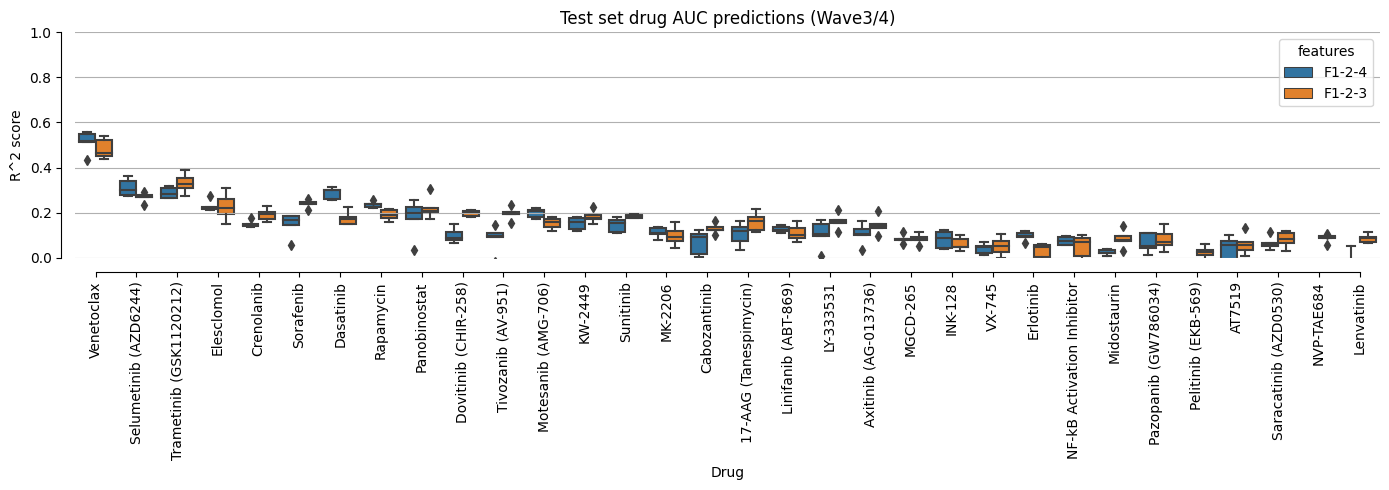

In [168]:
plt.figure(figsize=(14, 5))

results_top_drugs_f3b4 = results_top_drugs[results_top_drugs.features.isin(['F1-2-4', 'F1-2-3']) & (results_top_drugs.dataset=='wave34')]
sns.boxplot(x='target', y='r2_score_test', hue='features', data=results_top_drugs_f3b4, order=top_drugs)
plt.ylim(0, 1)

sns.despine(offset=10, trim=True)

plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Test set drug AUC predictions (Wave3/4)')
plt.ylabel('R^2 score')
plt.xlabel('Drug')
plt.tight_layout()
plt.savefig('test_drug_auc_pred_features_124_123.png', dpi=200)

### Visualizations for Venetoclax and Trametinib only

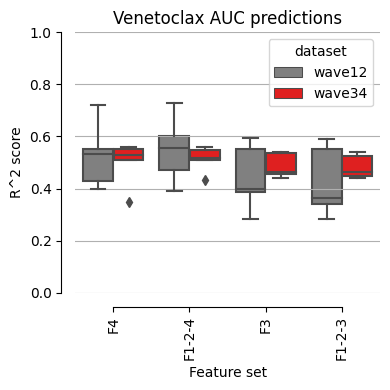

In [169]:
plt.figure(figsize=(4,4))
results_venetoclax = results_top_drugs[(results_top_drugs.target=='Venetoclax') & (results_top_drugs.features.isin(['F3', 'F4', 'F1-2-4', 'F1-2-3'])) ]
sns.boxplot(x='features', y='r2_score_test', hue='dataset', data=results_venetoclax, palette=['gray', 'red'])
plt.ylim(0, 1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.title('Venetoclax AUC predictions')
plt.ylabel('R^2 score')
plt.xlabel('Feature set')
plt.tight_layout()
plt.savefig('test_venetoclax_auc_pred_wave1234.png', dpi=300)

In [170]:
results_top_drugs.target.unique()

array(['17-AAG (Tanespimycin)', 'AT7519', 'Axitinib (AG-013736)',
       'Cabozantinib', 'Crenolanib', 'Dasatinib', 'Dovitinib (CHIR-258)',
       'Elesclomol', 'Erlotinib', 'INK-128', 'KW-2449', 'LY-333531',
       'Lenvatinib', 'Linifanib (ABT-869)', 'MGCD-265', 'MK-2206',
       'Midostaurin', 'Motesanib (AMG-706)', 'NF-kB Activation Inhibitor',
       'NVP-TAE684', 'Panobinostat', 'Pazopanib (GW786034)',
       'Pelitinib (EKB-569)', 'Rapamycin', 'Saracatinib (AZD0530)',
       'Selumetinib (AZD6244)', 'Sorafenib', 'Sunitinib',
       'Tivozanib (AV-951)', 'Trametinib (GSK1120212)', 'VX-745',
       'Venetoclax'], dtype=object)